ETAPE 1 : ANALYSE DE DONNEES

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import seaborn as sns
import ppscore as pps
from itertools import combinations
from scipy.stats import zscore
from scipy import stats

In [46]:
dataset_train = pd.read_csv('xtrainCyclodextrin.csv')
dataset_test = pd.read_csv('xtestCyclodextrin.csv')

In [47]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Host                     2940 non-null   object 
 1   CID_Host                 2940 non-null   int64  
 2   Guest                    2940 non-null   object 
 3   CID_Guest                1724 non-null   float64
 4   pH                       2940 non-null   float64
 5   T                        2940 non-null   float64
 6   Erreur                   1724 non-null   float64
 7   K                        2940 non-null   int64  
 8   logK                     1216 non-null   float64
 9   Reference                2940 non-null   object 
 10  Original_Value           2940 non-null   object 
 11  IsomericSMILES           2940 non-null   object 
 12  IsomericSMILES_Host      2940 non-null   object 
 13  TPSA                     2940 non-null   float64
 14  MolecularWeight         

In [48]:
dataset_train.isnull().sum()

Host                          0
CID_Host                      0
Guest                         0
CID_Guest                  1216
pH                            0
T                             0
Erreur                     1216
K                             0
logK                       1724
Reference                     0
Original_Value                0
IsomericSMILES                0
IsomericSMILES_Host           0
TPSA                          0
MolecularWeight               0
Complexity                    0
Charge                        0
HBondDonorCount               0
HBondAcceptorCount            0
HeavyAtomCount                0
MolLogP                       0
AromaticProportion            0
TPSA_Host                     0
MolecularWeight_Host          0
Complexity_Host               0
Charge_Host                   0
HBondDonorCount_Host          0
HBondAcceptorCount_Host       0
HeavyAtomCount_Host           0
iso2vec-0                     0
iso2vec-1                     0
iso2vec-

In [49]:
np.array([col for col in dataset_train.columns])

array(['Host', 'CID_Host', 'Guest', 'CID_Guest', 'pH', 'T', 'Erreur', 'K',
       'logK', 'Reference', 'Original_Value', 'IsomericSMILES',
       'IsomericSMILES_Host', 'TPSA', 'MolecularWeight', 'Complexity',
       'Charge', 'HBondDonorCount', 'HBondAcceptorCount',
       'HeavyAtomCount', 'MolLogP', 'AromaticProportion', 'TPSA_Host',
       'MolecularWeight_Host', 'Complexity_Host', 'Charge_Host',
       'HBondDonorCount_Host', 'HBondAcceptorCount_Host',
       'HeavyAtomCount_Host', 'iso2vec-0', 'iso2vec-1', 'iso2vec-2',
       'iso2vec-3', 'iso2vec-4', 'iso2vec-5', 'iso2vec-6', 'iso2vec-7',
       'iso2vec-8', 'iso2vec-9', 'iso2vec-host-0', 'iso2vec-host-1',
       'iso2vec-host-2', 'iso2vec-host-3', 'iso2vec-host-4',
       'iso2vec-host-5', 'iso2vec-host-6', 'iso2vec-host-7',
       'iso2vec-host-8', 'iso2vec-host-9'], dtype='<U23')

Dans notre jeu de données, nous avons:

Les variables catégoriques : "Host", "Guest", "Reference", "Original_Value","IsomericSMILES","IsomericSMILES_Host"

Nous avons décidé de n'est pas les prendre, par ce qu'ils portent pas d'information interessant pour notre etude:
- Toutes les caracteristiques qui peuvent etre represente par "IsomericSMILES" (resp. "IsomericSMILES_Host") sont mieux representés par les variables iso2vec (resp. iso2vec-host). De meme pour "Guest".
- "Reference", "Original_Value" et "Host" était plus une décision basée sur la performance du model pratiquement, en les representant numeriquement par OneHotEncoder pour "Host" et "Original_value" (puisque nous avons que 5 types de "Host" et 3 types de "Original_value"), et LabelEncoder pour "Reference" dans notre data. En effet, une premiere hypothese était que le type de molecule Host peut donner des informations utiles lors de notre entrainement, ce qui n'etait pas le cas, ce qui s'explique apres par le faite que d'autres variables representent mieux cette informations. 
Pour Original_value et Reference, c'était une remarque que toutes les individus ayant Original_Value = logK ont comme Reference = "Mizera, M.; Muratov, E.N.; Alves, V.M.; Tropsha, A.; Cielecka-Piontek, J. Computer-Aided Discovery of New Solubility-Enhancing Drug Delivery System. Biomolecules 2020, 10, 913. https://doi.org/10.3390/biom10060913", une valeur de logK present, et un Erreur manquant. Et toutes les autres reference ont une Original_Value DeltaG ou K,logK manquant et un Erreur present. D'ou l'heuristique que ensemble d'information peut donner des Aperçus sur la nature de l'Erreur (Cette hypothese est plus elaborees sur la partie consacrees à l'Erreur). Néanmoins, le résultat de l'entrainement à afficher des differences mineurs voir inexistant. D'ou la decision de les enlever.

Les variables numériques :
'CID_Host', 'CID_Guest', 'pH', 'T', 'Erreur','K','logK','TPSA','MolecularWeight','Complexity','Charge','HBondDonorCount','HBondAcceptorCount',
       'HeavyAtomCount', 'MolLogP', 'AromaticProportion', 'TPSA_Host',
       'MolecularWeight_Host', 'Complexity_Host', 'Charge_Host',
       'HBondDonorCount_Host', 'HBondAcceptorCount_Host',
       'HeavyAtomCount_Host', 'iso2vec-0', 'iso2vec-1', 'iso2vec-2',
       'iso2vec-3', 'iso2vec-4', 'iso2vec-5', 'iso2vec-6', 'iso2vec-7',
       'iso2vec-8', 'iso2vec-9', 'iso2vec-host-0', 'iso2vec-host-1',
       'iso2vec-host-2', 'iso2vec-host-3', 'iso2vec-host-4',
       'iso2vec-host-5', 'iso2vec-host-6', 'iso2vec-host-7',
       'iso2vec-host-8', 'iso2vec-host-9'

Nous avons enlevees : 
- 'CID_Host' et 'CID_Guest' pour deux raisons. le premier (qui est direct) c'est que les ID sont unique a chaque individu, et donc considere un tel type de variable ne portera pas d'information utile. deuxieme par ce que nous avons des ID manqauntes dans CID_Guest, et donc comme ils sonts des ID, Il n'y a pas un raisonnemnet logique pour les remplacer.
- 'Erreur' : plus de 1216 individus n'ont pas des valeurs de l'Erreur. La premiere tentative était de créer model de regression sur la valeur de l'Erreur, pour remplacer les valeurs manquantes de l'Erreur. cette tentative n'a pas abouti.
La deuxieme tentative (qui est en relation avec l'explication sur la partie pourquoi nous avons enlevees 'Reference' et 'Original_Value'), à partir de la remarque sur la relation entre 'OriginalValue', 'logK','Reference' et 'Erreur'. Nous avons éssayées de trouver une méthode pour approximer l'Erreur des autres individus manquant a partir de leurs logK, K et OriginalValue. Cette approche à deux fatalités; la premiere est le faite que trouver l'Erreur à parir de K et logK creer une  information additionelle sur K, et donc creer plus de correlation, ce qui est logiquement faux. La deuxieme, qui est la plus importante. c'est le faite que nous avons aucune information sur la signification des valeurs de l'Erreur. Après une recherche sur les differentes methodes de mesure dans l'industrie de chimie, nous avons trouvees que l'Erreur vient de plusieurs sources, et peuvent etre definit differement (Random Errors and Systematic Errors) [1]. Donc nous avons décidé de ne pas prendre l'Erreur en consideration vue la non clarete de la nature de l'Erreur.

- 'Charge_Host' : Toutes les individus ont la meme valeur de Charge_host (charge_host = 0), donc ce vecteur ne donne aucune information spécial à aucune individu, et pire le modele entraine par la suite peut perdre de généralité si envisagé avec une valeur de Charge_Host differente.  
[1] 


Pour les autres variables, une étude de correlation est nécessaire.

1. Nous commencons par une étude de correlation linéaire

In [50]:
x_train = dataset_train.drop(['Host','Original_Value','Guest','Erreur','CID_Host',"Reference","CID_Guest",'Charge_Host',"IsomericSMILES_Host","IsomericSMILES"],axis=1)

In [51]:
# Calcule de la variance pour les variables
correlation_matrix = x_train.corr()

# Affichage de matrice de variance
print("Variance Matrix for each feature:")
print(correlation_matrix)


Variance Matrix for each feature:
                               pH         T         K      logK      TPSA  \
pH                       1.000000  0.010740 -0.012467 -0.074624 -0.008661   
T                        0.010740  1.000000  0.026945  0.156425  0.020335   
K                       -0.012467  0.026945  1.000000  0.671210  0.003122   
logK                    -0.074624  0.156425  0.671210  1.000000 -0.037330   
TPSA                    -0.008661  0.020335  0.003122 -0.037330  1.000000   
MolecularWeight          0.015842  0.112884  0.092005  0.284254  0.599851   
Complexity               0.013147  0.108607  0.067350  0.221543  0.564760   
Charge                  -0.116027  0.001709 -0.067482  0.063987 -0.182580   
HBondDonorCount         -0.047070 -0.013568 -0.029446 -0.129296  0.726998   
HBondAcceptorCount       0.012719  0.063493  0.012206  0.070766  0.891855   
HeavyAtomCount           0.011562  0.112368  0.091804  0.287626  0.594778   
MolLogP                  0.001129  0.05781

Heatmap

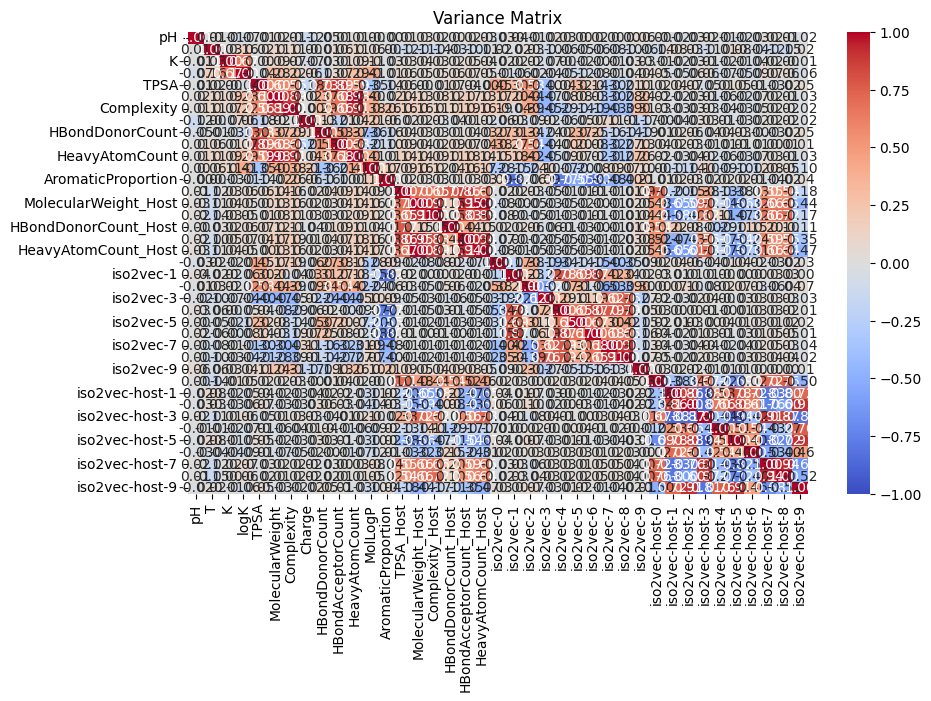

In [52]:

#Plot de la heatmap de la matrice de variance
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Variance Matrix')
plt.show()


In [10]:
correlation_matrix['K']

pH                        -0.012467
T                          0.026945
K                          1.000000
logK                       0.671210
TPSA                       0.003122
MolecularWeight            0.092005
Complexity                 0.067350
Charge                    -0.067482
HBondDonorCount           -0.029446
HBondAcceptorCount         0.012206
HeavyAtomCount             0.091804
MolLogP                    0.106027
AromaticProportion        -0.034169
TPSA_Host                  0.033475
MolecularWeight_Host       0.041855
Complexity_Host            0.033049
HBondDonorCount_Host       0.024325
HBondAcceptorCount_Host    0.049552
HeavyAtomCount_Host        0.042724
iso2vec-0                 -0.015304
iso2vec-1                  0.021938
iso2vec-2                  0.017654
iso2vec-3                 -0.067894
iso2vec-4                  0.003077
iso2vec-5                 -0.017185
iso2vec-6                 -0.000014
iso2vec-7                 -0.007496
iso2vec-8                 -0

In [11]:
correlation_matrix['logK']

pH                        -0.074624
T                          0.156425
K                          0.671210
logK                       1.000000
TPSA                      -0.037330
MolecularWeight            0.284254
Complexity                 0.221543
Charge                     0.063987
HBondDonorCount           -0.129296
HBondAcceptorCount         0.070766
HeavyAtomCount             0.287626
MolLogP                    0.406172
AromaticProportion        -0.012733
TPSA_Host                  0.064422
MolecularWeight_Host       0.049423
Complexity_Host            0.048775
HBondDonorCount_Host       0.064158
HBondAcceptorCount_Host    0.068624
HeavyAtomCount_Host        0.049892
iso2vec-0                 -0.014430
iso2vec-1                 -0.059748
iso2vec-2                 -0.020402
iso2vec-3                 -0.038188
iso2vec-4                 -0.048350
iso2vec-5                 -0.123886
iso2vec-6                 -0.083153
iso2vec-7                 -0.012136
iso2vec-8                 -0

A partir de la matrice de correlation lineaire, nous avons trois grandes observations : 
- La variable cible K a une correlation de l'ordre 10^-1 avec les autres variables (sauf MolLogP et logK).
- La variable logK est plus correles avec les autres variables.
- la matrice de correlation presente des regions ou la correlation est forte entre des sous ensembles de variables eg. Les iso2vec-host presentent une forte correlation entre eux.

Pour mieux voir ces differentes relations et une vision plus precise sur la nature de notre probleme, il faut cherchee les correlations lineaires et non lineaires, c'est pourquoi nous avons utilisee le Predictive Power Score pour capturer les correlations non linear

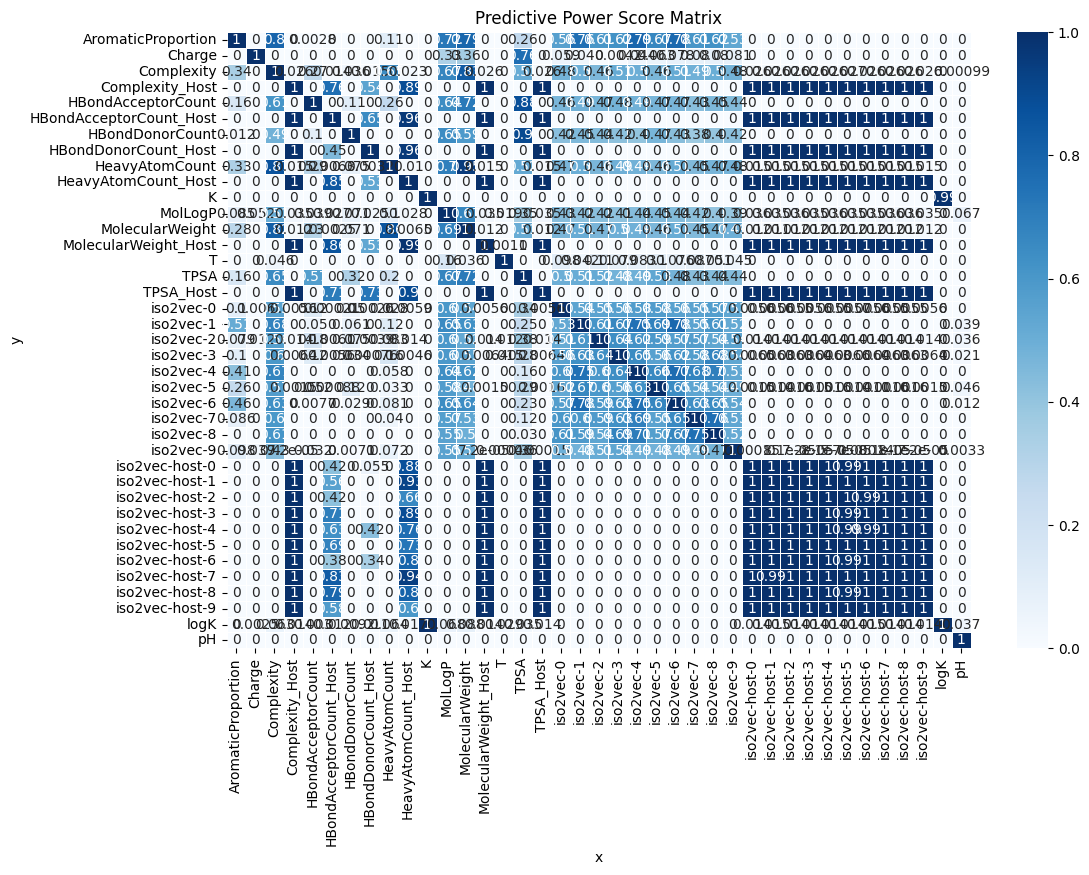

In [53]:


# Calculate the PPS matrix
pps_matrix = pps.matrix(x_train)

# Pivot the PPS matrix for better visualization
matrix_df = pps_matrix.pivot(index='y', columns='x', values='ppscore')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.title('Predictive Power Score Matrix')
plt.show()


In [13]:
matrix_df['K']

y
AromaticProportion         0.000000
Charge                     0.000000
Complexity                 0.000000
Complexity_Host            0.000000
HBondAcceptorCount         0.000000
HBondAcceptorCount_Host    0.000000
HBondDonorCount            0.000000
HBondDonorCount_Host       0.000000
HeavyAtomCount             0.000000
HeavyAtomCount_Host        0.000000
K                          1.000000
MolLogP                    0.000000
MolecularWeight            0.000000
MolecularWeight_Host       0.000000
T                          0.000000
TPSA                       0.000000
TPSA_Host                  0.000000
iso2vec-0                  0.000000
iso2vec-1                  0.000000
iso2vec-2                  0.000000
iso2vec-3                  0.000000
iso2vec-4                  0.000000
iso2vec-5                  0.000000
iso2vec-6                  0.000000
iso2vec-7                  0.000000
iso2vec-8                  0.000000
iso2vec-9                  0.000000
iso2vec-host-0            

In [14]:
print(matrix_df['logK'])

y
AromaticProportion         0.000000
Charge                     0.000000
Complexity                 0.000000
Complexity_Host            0.000000
HBondAcceptorCount         0.000000
HBondAcceptorCount_Host    0.000000
HBondDonorCount            0.000000
HBondDonorCount_Host       0.000000
HeavyAtomCount             0.000000
HeavyAtomCount_Host        0.000000
K                          0.988513
MolLogP                    0.000000
MolecularWeight            0.000000
MolecularWeight_Host       0.000000
T                          0.000000
TPSA                       0.000000
TPSA_Host                  0.000000
iso2vec-0                  0.000000
iso2vec-1                  0.000000
iso2vec-2                  0.000000
iso2vec-3                  0.000000
iso2vec-4                  0.000000
iso2vec-5                  0.000000
iso2vec-6                  0.000000
iso2vec-7                  0.000000
iso2vec-8                  0.000000
iso2vec-9                  0.000000
iso2vec-host-0            

On remarque que plusieurs sous ensembles de variables presentent des correlations tres fortes entre eux

A partir de la matrice de correlation lineaire et de la PPS, nous avons les infomations clés sur notre jeu de données:
1. Le jeu de données est  difficile dans son traitement puisqu'il ne présent pas des relations linéaires claires entre les variables et la variable cible, donc le choix de model sera cruciale. (Elaboration et jusification sur la partie choix du modele)
2. Une prédiction sur logK sera plus performante qu'une prediction sur K puisque logK est plus correle a d'autre variables que K. (Cette idée est plus élaborée sur la partie de distributions)
3. Il existe des sous ensembles de vecteurs ayant une correlation tres forte entre eux, donc une reduction de dimension est favorable par ce qu'il y'a repetition de l'information, qui peut cree de bruit additionelle. De plus, le modele entrainne sera plus efficace lors de l'entrainement et plus rapide lors l'entrainement et les predictions, et de plus diminue la chance d'avoir un overfitting. Donc, on va prendre un seule represenant pour chaque de sous ensemble en definissant un THRESHOLD de 0.8, bar min de correlation entre deux variables

In [54]:

correlation_threshold = 0.8

# Find all subsets of columns that are highly correlated within the group
def find_highly_correlated_groups(correlation_matrix, threshold):
    columns = correlation_matrix.columns
    n = len(columns)
    visited = set()
    correlated_groups = []

    for i in range(n):
        current_group = []
        for j in range(n):
            if i != j and abs(correlation_matrix.iloc[i, j]) > threshold:
                current_group.append(columns[j])
        if current_group:
            current_group.append(columns[i])  # Add the reference column itself
            current_group_set = frozenset(current_group)  # Use a set to ensure no duplicates
            if current_group_set not in visited:
                visited.add(current_group_set)
                correlated_groups.append(list(current_group_set))

    return correlated_groups

# Get the groups of highly correlated columns
highly_correlated_groups = find_highly_correlated_groups(matrix_df, correlation_threshold)

# Display the groups
print("Groups of Highly Correlated Columns:")
for group in highly_correlated_groups:
    print(group)

Groups of Highly Correlated Columns:
['MolecularWeight', 'Complexity']
['iso2vec-host-9', 'iso2vec-host-2', 'HeavyAtomCount_Host', 'iso2vec-host-8', 'TPSA_Host', 'iso2vec-host-5', 'Complexity_Host', 'iso2vec-host-0', 'iso2vec-host-1', 'iso2vec-host-3', 'iso2vec-host-4', 'iso2vec-host-7', 'iso2vec-host-6', 'MolecularWeight_Host']
['HBondAcceptorCount', 'TPSA']
['iso2vec-host-9', 'iso2vec-host-2', 'HeavyAtomCount_Host', 'iso2vec-host-8', 'TPSA_Host', 'HBondAcceptorCount_Host', 'iso2vec-host-5', 'iso2vec-host-6', 'iso2vec-host-0', 'iso2vec-host-1', 'iso2vec-host-3', 'iso2vec-host-4', 'iso2vec-host-7', 'Complexity_Host', 'MolecularWeight_Host']
['HBondDonorCount', 'TPSA']
['iso2vec-host-9', 'iso2vec-host-2', 'HeavyAtomCount_Host', 'iso2vec-host-8', 'TPSA_Host', 'HBondDonorCount_Host', 'iso2vec-host-5', 'iso2vec-host-6', 'iso2vec-host-0', 'iso2vec-host-1', 'iso2vec-host-3', 'iso2vec-host-4', 'iso2vec-host-7', 'Complexity_Host', 'MolecularWeight_Host']
['Complexity', 'MolecularWeight', 'Heav

In [55]:
Representatives = ['Complexity','HBondAcceptorCount_Host','HBondDonorCount_Host','HeavyAtomCount','iso2vec-host-0','TPSA','Complexity','TPSA_Host','Complexity_Host']

In [56]:
# Input data
Representatives = [
    'Complexity', 'HBondAcceptorCount_Host', 'HBondDonorCount_Host',
    'HeavyAtomCount', 'iso2vec-host-0', 'TPSA', 'TPSA_Host', 
    'Complexity_Host'
]
# Flatten all groups and remove duplicates
unique_columns = set(col for group in highly_correlated_groups for col in group)

# Filter out columns already in Representatives
columns_to_not_consider = [
    col for col in unique_columns if col not in Representatives
]

# Output result
print("columsn to not consider : ",(columns_to_not_consider))



columsn to not consider :  ['HeavyAtomCount_Host', 'iso2vec-host-5', 'iso2vec-host-3', 'logK', 'iso2vec-host-7', 'MolecularWeight', 'MolecularWeight_Host', 'iso2vec-host-8', 'iso2vec-host-1', 'K', 'iso2vec-host-4', 'iso2vec-host-6', 'HBondAcceptorCount', 'HBondDonorCount', 'iso2vec-host-9', 'iso2vec-host-2']


Maintenant que nous avons laisse que les variables ayant une valeur pour notre model, Nous etudions la distribution de la variable cible.

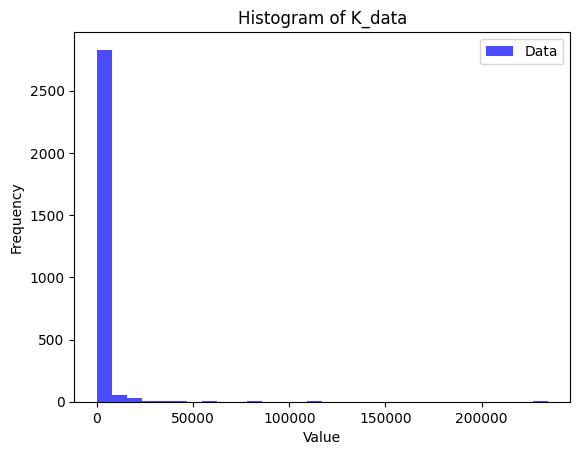

In [18]:
# Create the histogram
plt.hist(x_train['K'], bins=30, label='Data', color='blue', alpha=0.7)

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of K_data')
plt.legend()

# Display the plot
plt.show()


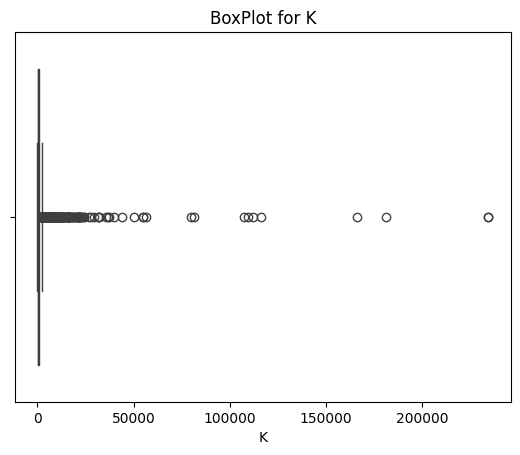

In [19]:
from scipy.stats import zscore
from scipy import stats
sns.boxplot(data=x_train, x="K")
plt.title("BoxPlot for K")
plt.show()

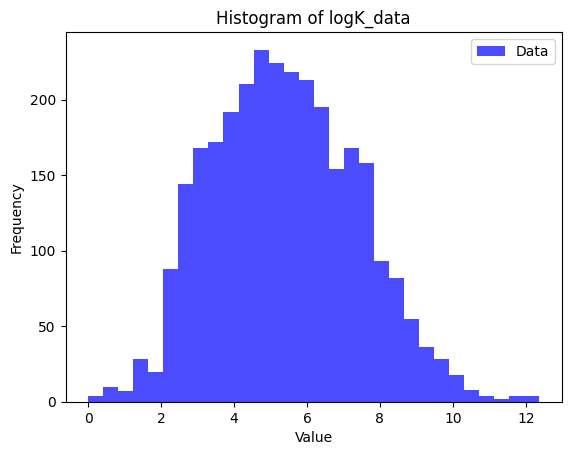

In [20]:
# Create the histogram
plt.hist(np.log(x_train['K']), bins=30, label='Data', color='blue', alpha=0.7)

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of logK_data')
plt.legend()

# Display the plot
plt.show()


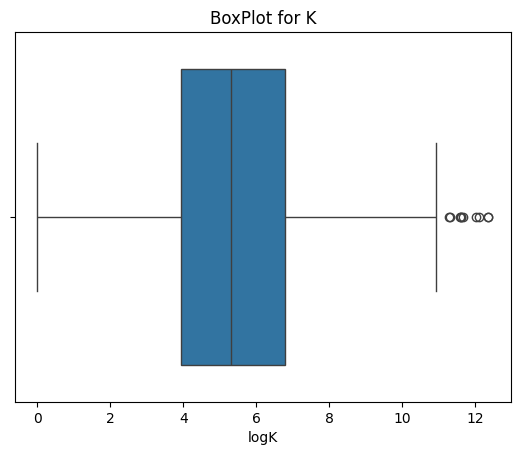

In [21]:

X = x_train.copy()
X['logK'] = np.log(X['K'])
sns.boxplot(data=X, x="logK")
plt.title("BoxPlot for K")
plt.show()

In [22]:
print(x_train['K'].max())

234423


A partir des plots ci-dessus : 
1. La distribution des valeurs de K est tres variante, avec des valeurs entre 1 et 234423.
2. La variable K admet des valeurs extreme, qui sont minoritaires, cela est bien affichee par le boxplot
3. La a distribution de logK est mieux adaptee, puisqu'elle plus proche à une distribution normale, de plus les valeurs de la variable sont dans un interval plus petit. Ce qui explique pourquoi il faut travailler avec logK pour la prediction et non pas K

C'est quoi la nature de la distribution de logK?

In [23]:
from scipy.stats import norm, gamma, logistic, laplace, cauchy, t
data = X['logK']
# Fit various distributions
norm_params = norm.fit(data)
gamma_params = gamma.fit(data)
logistic_params = logistic.fit(data)
laplace_params = laplace.fit(data)
cauchy_params = cauchy.fit(data)

# Test goodness-of-fit using K-S test
from scipy.stats import kstest

distributions = {
    'Normal': (norm, norm_params),
    'Gamma': (gamma, gamma_params),
    'Logistic': (logistic, logistic_params),
    'Laplace': (laplace, laplace_params),
    'Cauchy': (cauchy, cauchy_params)
}

for name, (dist, params) in distributions.items():
    stat, p = kstest(data, dist.name, args=params)
    print(f"{name}: Statistic={stat:.4f}, p={p:.4f}")


Normal: Statistic=0.0260, p=0.0370
Gamma: Statistic=0.0238, p=0.0696
Logistic: Statistic=0.0348, p=0.0016
Laplace: Statistic=0.0572, p=0.0000
Cauchy: Statistic=0.0974, p=0.0000


In [24]:
# Calculate log-likelihoods and AIC/BIC
aic_scores = {}
for name, (dist, params) in distributions.items():
    ll = np.sum(dist.logpdf(data, *params))
    k = len(params)  # Number of parameters
    aic = 2 * k - 2 * ll
    aic_scores[name] = aic

# Find the best fit
best_fit = min(aic_scores, key=aic_scores.get)
print(f"Best fit by AIC: {best_fit}")


Best fit by AIC: Gamma


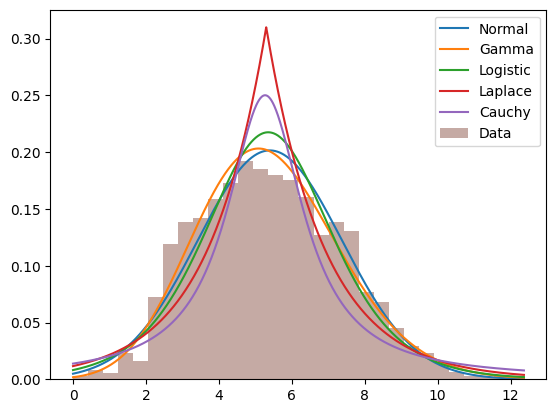

In [25]:

x = np.linspace(min(data), max(data), 1000)

for name, (dist, params) in distributions.items():
    pdf = dist.pdf(x, *params)
    plt.plot(x, pdf, label=name)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Data')
plt.legend()
plt.show()

In [26]:
print("Mean:", x_train['K'].mean(), ", Min:", x_train['K'].min(), ", Max:", x_train['K'].max())

List_of_vals = [1, 1000, 5000, 10000, 50000, 100000, 300000]
lengthx = x_train.shape[0]

for i in range(len(List_of_vals) - 1):
    # Calculate the number of rows within the range
    length = len(x_train[(x_train['K'] > List_of_vals[i]) & (x_train['K'] <= List_of_vals[i + 1])])
    
    # Print the range, length, and percentage
    print(
        f"{List_of_vals[i]} < K <= {List_of_vals[i + 1]}: {length}, "
        f"Percentage: {length / lengthx * 100:.2f}%"
    )

# print("1 < K < 100:", len(x_train[(x_train['K'] > 1) & (x_train['K'] <= 100)]))
# print("100 < K < 500:", len(x_train[(x_train['K'] > 100) & (x_train['K'] <= 500)]))
# print("500 < K < 1000:", len(x_train[(x_train['K'] > 500) & (x_train['K'] <= 1000)]))
# print("1000 < K < 2000:", len(x_train[(x_train['K'] > 1000) & (x_train['K'] <= 2000)]))
# print("2000 < K < 3000:", len(x_train[(x_train['K'] > 2000) & (x_train['K'] <= 3000)]))
# print("3000 < K < 5000:", len(x_train[(x_train['K'] > 3000) & (x_train['K'] <= 5000)]))
# print("5000 < K < 10000:", len(x_train[(x_train['K'] > 5000) & (x_train['K'] <= 10000)]))
# print("10000 < K < 100000:", len(x_train[(x_train['K'] > 10000) & (x_train['K'] <= 100000)]))
# print("100000 < K < 250000:", len(x_train[(x_train['K'] > 100000) & (x_train['K'] <= 250000)]))

Mean: 1787.1710884353743 , Min: 1 , Max: 234423
1 < K <= 1000: 2247, Percentage: 76.43%
1000 < K <= 5000: 512, Percentage: 17.41%
5000 < K <= 10000: 91, Percentage: 3.10%
10000 < K <= 50000: 72, Percentage: 2.45%
50000 < K <= 100000: 6, Percentage: 0.20%
100000 < K <= 300000: 8, Percentage: 0.27%


Donc dans notre cas, la meilleur fit pour logK est la distribution Gamma. 
Cela veut dire quoi dans notre cas ?
Notre jeu de donnees est relativement petit, avec des valeurs de K variant de minK = 1 et maxK = 234423. Plus précisement:
Mean: 1787.1710884353743 , Min: 1 , Max: 234423
1 < K <= 1000: 2247, Percentage: 76.43%
; 1000 < K <= 5000: 512, Percentage: 17.41%
; 5000 < K <= 10000: 91, Percentage: 3.10%
; 10000 < K <= 50000: 72, Percentage: 2.45%
; 50000 < K <= 100000: 6, Percentage: 0.20%
; 100000 < K <= 300000: 8, Percentage: 0.27%
Donc le nombre de K ayant une value entre 1 et 1000 est majoritaire, tandis que les K ayant une valeur K>10000 est tres petit par rapport aux autres.
Pour une distribution gamma, cela se traduit par : 
1. **Asymétrie** : La forte asymétrie implique que les mesures traditionnelles comme la moyenne peuvent ne pas représenter pleinement la valeur "typique" de K .

2. **Valeurs aberrantes** : La présence de très grandes valeurs (par exemple, max \( = 234,423 \)) devrait être analysée avec attention. Ces valeurs aberrantes peuvent dominer certains calculs, comme les moyennes.

3. Il pourrait être nécessaire d'appliquer des transformations (dans notre cas nous choisissons une transformation logarithmique) ou d'utiliser des méthodes robustes (nous verrons par la suite que nous utilisons des forets aleatoires pour mieux faire l'entrainement) pour gérer efficacement les valeurs extrêmes.

A partir des differents interpretations jusqu'a maintenant, une prediction sur logK devra etre mieux qu'une prediction sur K. D'ou par la suite, notre prediction (et etude) sera faite sur logK et non plus K.

LES OUTLIERS

Clairement, notre model represente des outliers pour les grandes valeurs de K. cela est visiblement claire par un boxplot, mais nous pouvons raffiner un peu plus en utilisos DBSCAN qui donne une idee plus claire puisqu'il est un algorithme qui depend des deux parametres principaux eps qui est la tolerance pour considerer deux voisins dans le cluster, et min_sampels est le nombre d'individus minimal pour prendre en consideration un cluster.

Apres un fine-tuning sur les differentes parametres eps et min_samples de DBSCAN pour trouver les outliers en se basant sur leur importance. Nous avons trouver eps = 0.005 et min_samples=9
L'algorithme DBSCAN trouve alors un nombre d'outliers = 246. Cela reduit significativement l'Erreur MAE et RMSE du model, et augmente son score R2.
Neanmoins, nous avons decidee de ne pas eliminer les outliers par ce que les algorithmes de machine learning reposent sur ces deux principes fondamentaux : l'apprentissage à partir des données et la généralisation de nouvelles données. Si nous considerons pas les outliers, nous auront un model plus performant sur les donnees de K dans un intervalle specifique, néanmoins le model ne sera pas capable à se généraliser à partir d'autres données. De plus, a partir des donnes et a partir d'une recherche sur la nature de K montre que les individus ayant les K les plus élevees sont les individus les plus précis lors de leurs mesure, et Donc en eliminant les outliers, on risk de perdre des informations de qualité. 

In [27]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = x_train.copy()
selected_columns = ['K'] #['K','Erreur'] when I only consider K, the model gets significanntly better, idk why?
X_sel = X[selected_columns]

# 2. Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sel)

# 3. Apply DBSCAN
dbscan = DBSCAN(eps=0.005, min_samples=9)  #I got these parameters after fine tuning
labels = dbscan.fit_predict(X_scaled)

# 4. Identify outliers
X['Cluster'] = labels
outliers = X[X['Cluster'] == -1]

print("Original Data:")
print(X.shape)
print("\nOutliers:")
print(outliers[['K']])

Original Data:
(2940, 40)

Outliers:
           K
9      37300
27      9420
38      6000
54    107358
58      9560
...      ...
2863    8100
2873    5777
2885    6627
2896    4434
2925   12700

[246 rows x 1 columns]


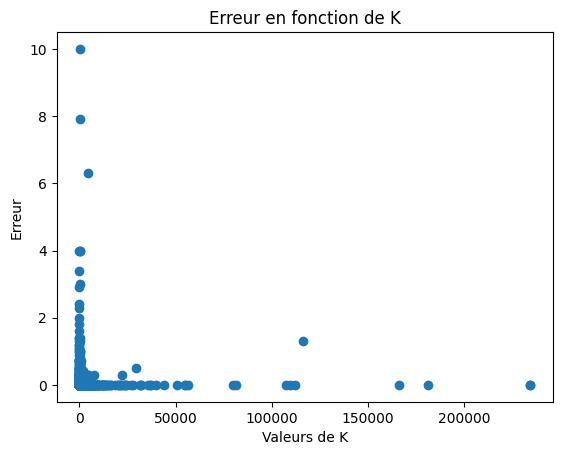

In [28]:
plt.scatter(dataset_train['K'],dataset_train['Erreur'])
plt.title("Erreur en fonction de K")
plt.xlabel("Valeurs de K")
plt.ylabel("Erreur")
plt.show()

ETAPE 2: CHOIX DU MODELE DE REGRESSION

Premierement, le choix du modele est basee sur les apercues donnes par le traitement de donnees fait, On a trouvé que :
1. La correlation entre la variable cible logK et les autres variables sont faibles.
2. Les relations entre les variables du jeu de donnes ne sont pas evident, et non pas lineaire.
3. Les valeurs des variables ne sont pas dans le meme echelle, et peuvent varier largement.
Deux approches sont possibles :
- Travailler avec des modeles sensible  à l'echelle des valeurs des variables en normalisant les differentes variables. Des modeles comme la regression polynomiale ou SVR.
- Travailler avec des modeles qui ne sont pas sensible à l'echelle des valeurs des variables comme les arbres de decision.

Le meilleur choix dans notre cas est de travailler avec les arbres de decision (voir foret aleatoire). En effet, la nature des algorithms basées sur les forets aléatoires n'est pas sensible a l'echelle des valuers, gere les mieux les outliers et le plus important elle est capable de trouver des relation non lineair entre les differentes variables de notre jeu de données. Le choix est justifiée pour les 4 raisons qui suivent : 


1. Gestion Sophistiquée des Relations Complexes dans les Données
   
   Les Forêts Aléatoires, constituées d'un ensemble d'arbres de décision, excellent dans la modélisation des relations non linéaires pour plusieurs raisons fondamentales :

- Frontières de Décision Non Linéaires : Les arbres créent des frontières de décision constantes par morceaux, permettant de capturer des motifs non linéaires qu'un modèle linéaire classique ne pourrait pas détecter. L'agrégation de multiples arbres renforce considérablement cette capacité de modélisation complexe.
- Interactions Multidimensionnelles : La structure même des arbres de décision permet une analyse fine des interactions entre variables. Par exemple, l'importance d'une variable peut varier significativement selon les valeurs prises par d'autres variables, créant ainsi une modélisation dynamique et contextuelle.
- Échantillonnage Bootstrap et Agrégation : Chaque arbre est construit sur un sous-ensemble aléatoire distinct des données, permettant la découverte de relations spécifiques qui pourraient être masquées dans une analyse globale. L'agrégation des prédictions (bagging) synthétise ces découvertes multiples en un modèle robuste.

2. Indépendance vis-à-vis de la Normalisation des Variables

   Contrairement aux algorithmes basés sur les distances (comme les k-plus proches voisins), les Forêts Aléatoires présentent une caractéristique remarquable : l'absence de nécessité de normalisation des variables, pour plusieurs raisons :

- Logique Ordinale : Les arbres opèrent sur l'ordre relatif des valeurs plutôt que sur leurs magnitudes absolues, donc la structure décisionnelle reste identique.
- Critères de Division Intrinsèques : Les métriques utilisées (comme l'impureté de Gini ou le gain d'information) sont invariantes par transformation monotone des variables. Cette propriété garantit une stabilité remarquable face aux différentes échelles de mesure.
- Robustesse Structurelle : La nature même du processus décisionnel, basé sur des comparaisons relatives plutôt que sur des valeurs absolues, assure une immunité naturelle aux problèmes d'échelle.

3. Maîtrise Sophistiquée du Surapprentissage

Le contrôle du surapprentissage s'effectue à travers plusieurs mécanismes complémentaires :

- Moyenne Ensembliste : L'agrégation des prédictions de multiples arbres indépendants réduit la variance globale du modèle. Cette approche collective diminue le risque que des particularités non représentatives du jeu d'entraînement ne contaminent les prédictions.
- Sélection Aléatoire des Variables : À chaque nœud, seul un sous-ensemble aléatoire de variables est considéré pour la division. Cette contrainte force le modèle à explorer diverses perspectives d'analyse, évitant ainsi une dépendance excessive à certaines variables.
- Estimation Out-of-Bag : L'utilisation des échantillons non sélectionnés lors du bootstrap comme ensemble de validation permet une évaluation non biaisée de la performance du modèle, facilitant la détection précoce du surapprentissage.

4. Robustesse par Apprentissage d'Ensemble

La force des Forêts Aléatoires réside dans leur nature d'ensemble, qui offre plusieurs avantages :

- Diversification Systématique : La combinaison de la randomisation des données et des variables crée une diversité structurelle qui renforce la robustesse du modèle.
- Résistance aux Valeurs Aberrantes : L'agrégation des prédictions multiples dilue naturellement l'influence des observations atypiques, produisant un modèle plus stable et fiable.

Neanomoins nous avons quand meme compares les differents modeles et nous avons trouvez les resultats suivants :


In [125]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Suggested hyperparameters
ridge_params = {"alpha": 1.0}  # L2 regularization strength
lasso_params = {"alpha": 0.01}  # L1 regularization strength
poly_degree = 3  # Degree of polynomial
svr_params = {"kernel": "rbf", "C": 100, "gamma": 0.1}  # Support Vector Regression
rf_params = {"n_estimators": 100, "max_depth": 10, "random_state": 42}  # Random Forest

# Initialize models with parameters
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(**ridge_params),
    "Lasso Regression": Lasso(**lasso_params),
    "Polynomial Regression": Pipeline([
        ('poly', PolynomialFeatures(degree=poly_degree)),
        ('linear', LinearRegression())
    ]),
    "Support Vector Regression": SVR(**svr_params),
    "Random Forest": RandomForestRegressor(**rf_params),
}

# Metrics storage
metrics = {
    "Model": [],
    "MAE": [],
    "RMSE": [],
    "R2": []
}

# Standardize the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X)

# Fit and evaluate each model
for name, model in models.items():
    # Cross-validation for metrics
    cv_mae = -cross_val_score(model, x_train_scaled, y_train.values, cv=5, scoring='neg_mean_absolute_error').mean()
    cv_rmse = np.sqrt(-cross_val_score(model, x_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    cv_r2 = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring='r2').mean()

    # Store metrics
    metrics["Model"].append(name)
    metrics["MAE"].append(cv_mae)
    metrics["RMSE"].append(cv_rmse)
    metrics["R2"].append(cv_r2)

    print(f"{name} - MAE: {cv_mae:.3f}, RMSE: {cv_rmse:.3f}, R2: {cv_r2:.3f}")

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)



Linear Regression - MAE: 1.354, RMSE: 1.704, R2: 0.257
Ridge Regression - MAE: 1.354, RMSE: 1.704, R2: 0.257
Lasso Regression - MAE: 1.358, RMSE: 1.706, R2: 0.255
Polynomial Regression - MAE: 8674489027.016, RMSE: 227821733789.370, R2: -13776454464885355446272.000
Support Vector Regression - MAE: 0.956, RMSE: 1.430, R2: 0.477
Random Forest - MAE: 0.955, RMSE: 1.279, R2: 0.582

Model Performance Comparison:
                       Model           MAE          RMSE            R2
0          Linear Regression  1.353959e+00  1.703711e+00  2.567116e-01
1           Ridge Regression  1.353936e+00  1.703554e+00  2.568441e-01
2           Lasso Regression  1.358471e+00  1.705784e+00  2.548753e-01
3      Polynomial Regression  8.674489e+09  2.278217e+11 -1.377645e+22
4  Support Vector Regression  9.560159e-01  1.430304e+00  4.768428e-01
5              Random Forest  9.554586e-01  1.278684e+00  5.817419e-01


In [129]:
print("\nModel Performance Comparison:")
metrics_df


Model Performance Comparison:


,Model,MAE,RMSE,R2
0,Linear Regression,1.353959e+00,1.703711e+00,2.567116e-01
1,Ridge Regression,1.353936e+00,1.703554e+00,2.568441e-01
2,Lasso Regression,1.358471e+00,1.705784e+00,2.548753e-01
3,Polynomial Regression,8.674489e+09,2.278217e+11,-1.377645e+22
4,Support Vector Regression,9.560159e-01,1.430304e+00,4.768428e-01
5,Random Forest,9.554586e-01,1.278684e+00,5.817419e-01


Donc notre hypothese sur l'efficacite de Foret aleatoire dans notre cas et verifiee puisque Random Forest perform mieux que toute les autres models


Le modele de choix est le XGBoost Regressor (Extreme Gradient Boosting), qui est un model basee sur foret aleatoire avec le boosting, qui est utile dans notre cas par ce que nous travaillons tout d'abord avec une base de données ayant des relation non-lineair et non evident, et deuxiement, par a cause du boosting du modele. Les differentes etapes de fonctionnement de ce model son expliquer ci-dessous

Première Phase : Initialisation

Le modèle commence par établir une prédiction initiale (F₀) correspondant à la moyenne de la variable cible. Cette valeur sert de point de départ pour les améliorations successives :

F₀(x) = argmin Σᵢ L(yᵢ, γ)
où L représente la fonction de perte (erreur quadratique pour la régression).

Deuxième Phase : Construction Itérative
À chaque itération m, XGBoost ajoute un nouvel arbre de décision hₘ(x) qui vise à corriger les erreurs résiduelles :

Fₘ(x) = Fₘ₋₁(x) + η × hₘ(x)
où :

Fₘ(x) représente le modèle à l'itération m

η est le taux d'apprentissage (learning rate)

hₘ(x) est le nouvel arbre ajouté

Optimisation : 

Pour chaque observation i à l'itération t, le modèle calcule :

Le gradient :

gᵢ = ∂L(yᵢ, Fₜ₋₁(xᵢ))/∂Fₜ₋₁(xᵢ)

Le hessien  :

hᵢ = ∂²L(yᵢ, Fₜ₋₁(xᵢ))/∂Fₜ₋₁(xᵢ)²

Ce utilisation du gradient et hessien permet une convergence plus rapide et plus précise.

Régularisation : 

XGBoost implémente une régularisation multi-niveaux : Ω(f) = γT + 1/2 λ||w||², où :

T est le nombre de feuilles dans l'arbre

w représente les scores des feuilles

γ et λ sont des paramètres de régularisation

Cette formulation permet un contrôle fin de la complexité du modèle, évitant le Overfitting tout en maintenant une capacité prédictive élevée.

Pour la Regression, XGBoost excelle dans la capture des relations non linéaires grâce à sa construction séquentielle d'arbres. Chaque nouvel arbre peut se concentrer sur des aspects spécifiques de la relation entre variables, permettant une modélisation très fine des interactions complexes.


Le modèle intègre naturellement une résistance aux outliers grâce à :


Sa fonction de perte.

Son processus d'apprentissage graduel qui peut atténuer l'impact des observations extrêmes.

PARAMETERS TUNING : le xgboost est puissant, neanmoins il est tres sensible au different parametre, la solution est de commencer par de parametres qui donne des resultats resonables, et essayer de raffiner au fur et a mesure les parametres pour que le modele puisse donner des valeurs de mae,rmse et r2 meilleurs. ce raffinement etait par une methode iterative qui combine differente parametres suciptible a ameliorer le modele en le evaluant sur les scores mae,rmse et r2. Apres ce raffinement, les meilleurs parametres trouvees pour le xgboost sont : 'learning_rate': 0.01, 'gamma': 0.01, 'n_estimators': 400, 'max_depth': 11, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8, 'booster': 'gbtree', 'random_state': 42

In [130]:
lr, Gamma, n_est, md, sub, col, Rega, Regl =  [0.01, 0.01, 400, 11, 0.6, 0.8, 0.1, 1.5] ##I got these parameters after fine tuning, see Untitled11
best_params = {"learning_rate" : lr, 
               "gamma" : Gamma, 
               "n_estimators" : n_est, 
                "max_depth":md,
                "reg_lambda":Regl,
               "reg_alpha":Rega,
               "subsample":sub,
               "colsample_bytree":col,
              "booster" : 'gbtree', 
              "random_state":42}

In [131]:
XG_reg = XGBRegressor(
    **best_params
) 

In [59]:
from sklearn.model_selection import cross_val_score

def MAE_score(model,x,y):
    scores = cross_val_score(estimator=model, X=x.values, y=y.values, cv=5,scoring = 'neg_mean_absolute_error')  # 5-fold CV is relevant to get an idea of the model's performance
    print(f"MAE Scores: {-scores}")
    print(f"Mean MAE Score en logK: {-scores.mean()} (+/- {scores.std()})")
def RMSE_score(model,x,y):
    scores = cross_val_score(estimator=model, X=x.values, y=y.values, cv=5,scoring = 'neg_mean_squared_error') # 5-fold CV is relevant to get an idea of the model's performance
    scores = np.sqrt(-scores)
    print(f"RMSE Scores: {scores}")
    print(f"Mean RMSE Score en logK: {scores.mean()} (+/- {scores.std()})")
def R2_score(model,x,y):
    scores = cross_val_score(estimator=model, X=x.values, y=y.values, cv=5,scoring = 'r2')  # 5-fold CV is relevant to get an idea of the model's performance
    print(f"R2 Scores: {scores}")
    print(f"Mean R2 Score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Avec ce choix de modele, les resultats des MAE,RMSE et R2 sur une K-Fold cross validation avec K=5 sont respectivement 0.856, 1.196 et 0.633 comme moyenne

In [110]:
Xt = x_train.copy()
Xt = Xt.drop(columns_to_not_consider,axis=1)

In [111]:
MAE_score(XG_reg,X,y_train)
RMSE_score(XG_reg,X,y_train)
R2_score(XG_reg,X,y_train)

MAE Scores: [0.8767545  0.88072783 0.85083517 0.84923518 0.82568883]
Mean MAE Score en logK: 0.8566483033306174 (+/- 0.020155982919780047)
RMSE Scores: [1.22275348 1.22749168 1.19048198 1.18486717 1.15888722]
Mean RMSE Score en logK: 1.19689630451987 (+/- 0.025436998276650254)
R2 Scores: [0.64363995 0.6209514  0.62606696 0.62736242 0.64831869]
Mean R2 Score: 0.633 (+/- 0.021)


LE RISQUE DE L'OVERFITTING
Apres entrainement du model et son evaluation, il a bien afficher scores meilleur avec n_estimators > 400, neanmoins les predictions du test ont donnes des valeurs negatifs, ce qui peut etre interprete comme un overfitting du model. Apres plusieurs essait et fine tuning, le choix precis de n_estimators est alros de 400 avec les differentes autres parametres.

SKEWNESS 

Skewness de logK

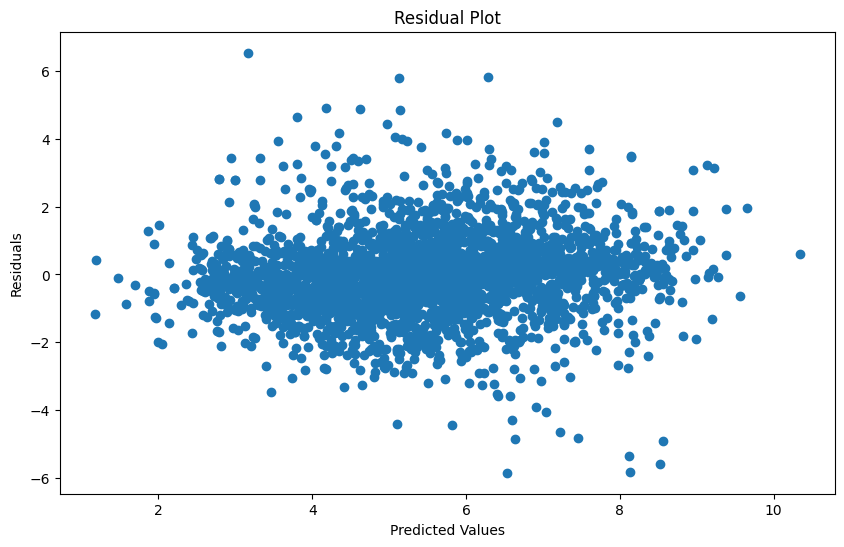

In [117]:
from sklearn.model_selection import cross_val_predict
y_pred_on_train = cross_val_predict(estimator=XG_reg,X=Xt,y=y_train,cv=5)
residuals_logK = y_train - y_pred_on_train
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_on_train, residuals_logK)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()
##Funnel shaped?

Le plot montre que la distribution des residus est proche d'etre aleatoire, verifie la condition de variance, Zero Mean,Independence of Residuals,Normality of Residuals et No Outliers. Donc notre model arrive à predire les valeurs de logK.

Skewness de K

DE L'ESPACE DE LOGK VERS L'ESPACE DE K

Pour faire le plot de residus de K, il faut respecter le fait que nous avons faire les predictions sur logK, et non pas K; c'ést à dire que la transformation de l'espace de logK à l'espace de K directement sera biaisé et va augmenter l'erreur associer au predictions de K à cause de la nature de l'exponentielle. Donc, apres prediction sur les valeurs de logK, pour calculer K, il faut appliquer la relation K = exp(logK + (sigma^2)/2), ou sigma represente l'ecart type des residus_logK. Cette situation est connue par : "Bias correction for log-transformed regression"[4]

RESIDUAL de K

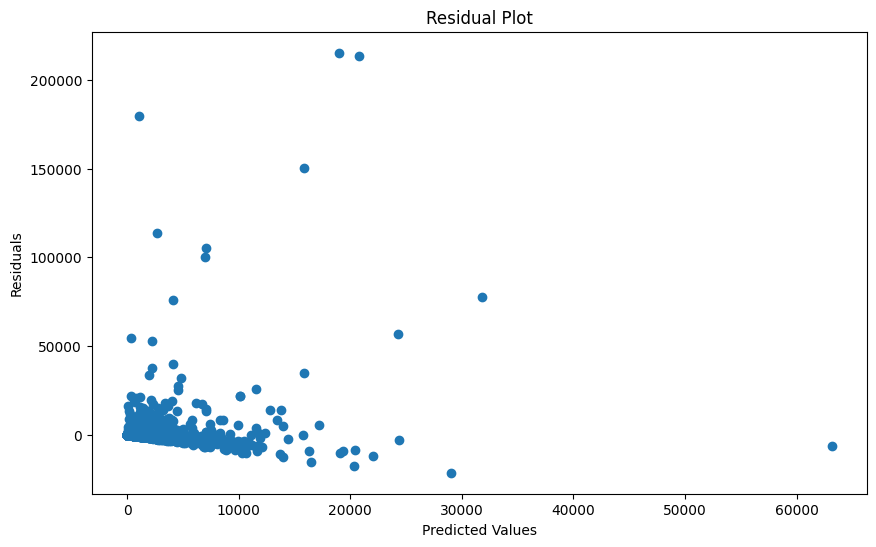

In [119]:
sigma_squared = np.var(residuals_logK,ddof=1) #ddof=1 signifie une division par n-1, ce qui est l'etat d'art pour cette technique
K_pred = np.exp(y_pred_on_train+sigma_squared/2)
residuals_K = np.exp(y_train) - K_pred
plt.figure(figsize=(10, 6))
plt.scatter(K_pred, residuals_K)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Ce plot de Residus viole les differentes conditions d'une bonne prediction et montre alors que de plus en plus les valeurs de K augmentent de plus l'Erreur. Cela est encore une autre justification sur pourquoi le choix de logK comme variable cible est meilleur que K

III. FEATURE EXTRACTION AND FEATURE ENGINEERING
Apres l'analyse de donnees, le choix du model, son entrainement,evaluation et fine tuning des parametrs, le resultat final n'est pas tres satisfaisant, avec un MAE = 0.84, RMSE = 1.19 et R2 = 0.64 comme meilleur scores sur une cross_validation. L'analyse de donnes et le raffinement de modele n'as pas un impact claire sur le performance du model. Donc nous avons essaye d'utiliser des techniques plus avancees pour trouver des relations possiblement cachees entre les differentes variables de notre jeu de donnes. La difficulte vient de la non connaissance de quelles variables ayant des relations cachees peut etre dans la data. 

Tout ce travail et plus était grace aux plusieurs ressources en ligne et forums comme StackOverflow. La source de choix est [2]

Nous regardons tout d'abord c'est quoi la nature des variables de notre data

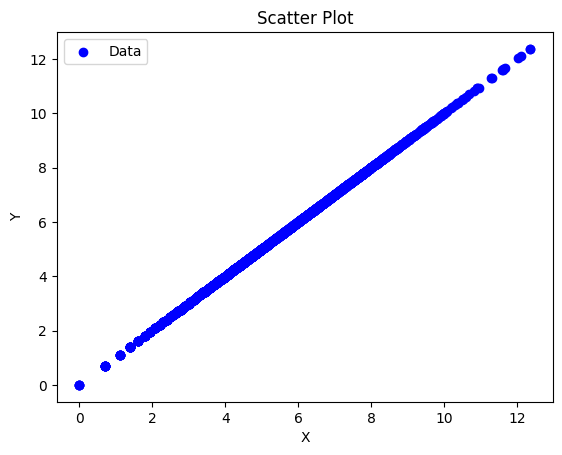

Linear Regression:
MSE: 2.8306995507136925
R^2: 0.2773888252359251

Polynomial Regression (Degree 3):
MSE: 0.23098856105933954
R^2: 0.9410340403586566


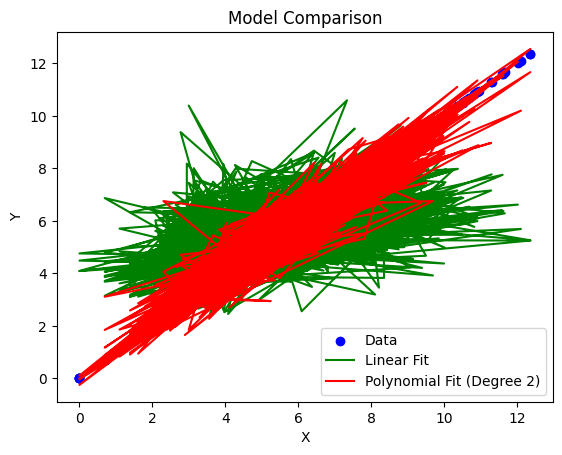

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_train = np.log(x_train['K'])
X = x_train.drop(columns_to_not_consider,axis=1)
# Scatter plot of the data
plt.scatter(np.log(dataset_train['K']), y_train, color='blue', label='Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot')
plt.legend()
plt.show()


# Linear regression
linear_model = LinearRegression()
linear_model.fit(X, y_train)
y_pred_linear = linear_model.predict(X)

# Polynomial regression (degree 2)
poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(x_poly, y_train)
y_pred_poly = poly_model.predict(x_poly)

# Evaluate models
print("Linear Regression:")
print("MSE:", mean_squared_error(y_train, y_pred_linear))
print("R^2:", r2_score(y_train, y_pred_linear))

print("\nPolynomial Regression (Degree 3):")
print("MSE:", mean_squared_error(y_train, y_pred_poly))
print("R^2:", r2_score(y_train, y_pred_poly))

# Plot results
plt.scatter(np.log(dataset_train['K']), y_train, color='blue', label='Data')
plt.plot(np.log(dataset_train['K']), y_pred_linear, color='green', label='Linear Fit')
plt.plot(np.log(dataset_train['K']), y_pred_poly, color='red', label='Polynomial Fit (Degree 2)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Model Comparison')
plt.legend()
plt.show()


Ce plot affiche les une regression lineaire sur logK (resp. une regression Polynomial sur logK). A partir de la distribution, on remarque qu'une distribution polynomial est beaucoup plus meuilleur qu'une distribution Lineaire, donc le model de la regression Polynomial arrive à mieux trouver les relations entre les differentes variables, ce qui peut etre un indice sur le feature Engineering que nous pourrons faire, eg. Creer une nouvelle variable Complexite^3, qui peut mieux mettre en valeur l'interet de la variable 'Complexite'.

Une premiere tentative est d'essayer de faire A+B, A-B, A*B et A/B pour differentes variables A et B de notre jeu de données, et d'essayer d'appliquer le log, la racine carree (sqrt), exp(-X) pour X une variable,la puissance de 2,3... à plusieurs variables pour captures des relations et correlations potentiellement cachees. 
Cette tentative echoue, puisqu'elle n'arrive pas a capturer de nouvelles relations et de creer plus de correlation entre les variables.

La premiere etape est de voire la distribution des differentes variables, en essayant de trouver des relations potentielles.

In [40]:
for col in X.columns:
    print(col,np.min(X[col]),np.max(X[col]),np.mean(X[col]))

pH 1.1 11.3 6.929425170068028
T 287.0 323.0 297.8255442176871
TPSA 0.0 239.97 48.292697278911575
Complexity 0.0 1822.6770407927388 372.5700210689837
Charge -3 2 -0.03197278911564626
HeavyAtomCount 1 42 14.66326530612245
MolLogP -4.124 9.079900000000002 1.9724173231292523
AromaticProportion 0.0 1.0 0.3942226651771768
TPSA_Host 249.2099999999999 857.6400000000004 537.8347482993199
Complexity_Host 1233.4857443469036 3047.539510771213 1516.9547088589127
HBondDonorCount_Host 0 24 19.607142857142858
HBondAcceptorCount_Host 27 49 34.49115646258503
iso2vec-0 -0.7876928 1.5513912 0.2800654935390374
iso2vec-1 -2.662436 1.1156886 -0.7652864809364899
iso2vec-2 -2.1133866 0.41314438 -0.3832133241656871
iso2vec-3 -0.18859997 3.3309464 0.9388299812541155
iso2vec-4 -0.9839139 3.0790162 0.15198372886343164
iso2vec-5 -1.1286232 0.8065633 -0.26788116830629255
iso2vec-6 -1.2576653 2.3802636 0.012804075237176868
iso2vec-7 -0.46666822 2.7333593 0.3690916269235085
iso2vec-8 -0.2288934 4.1727934 0.68504117543

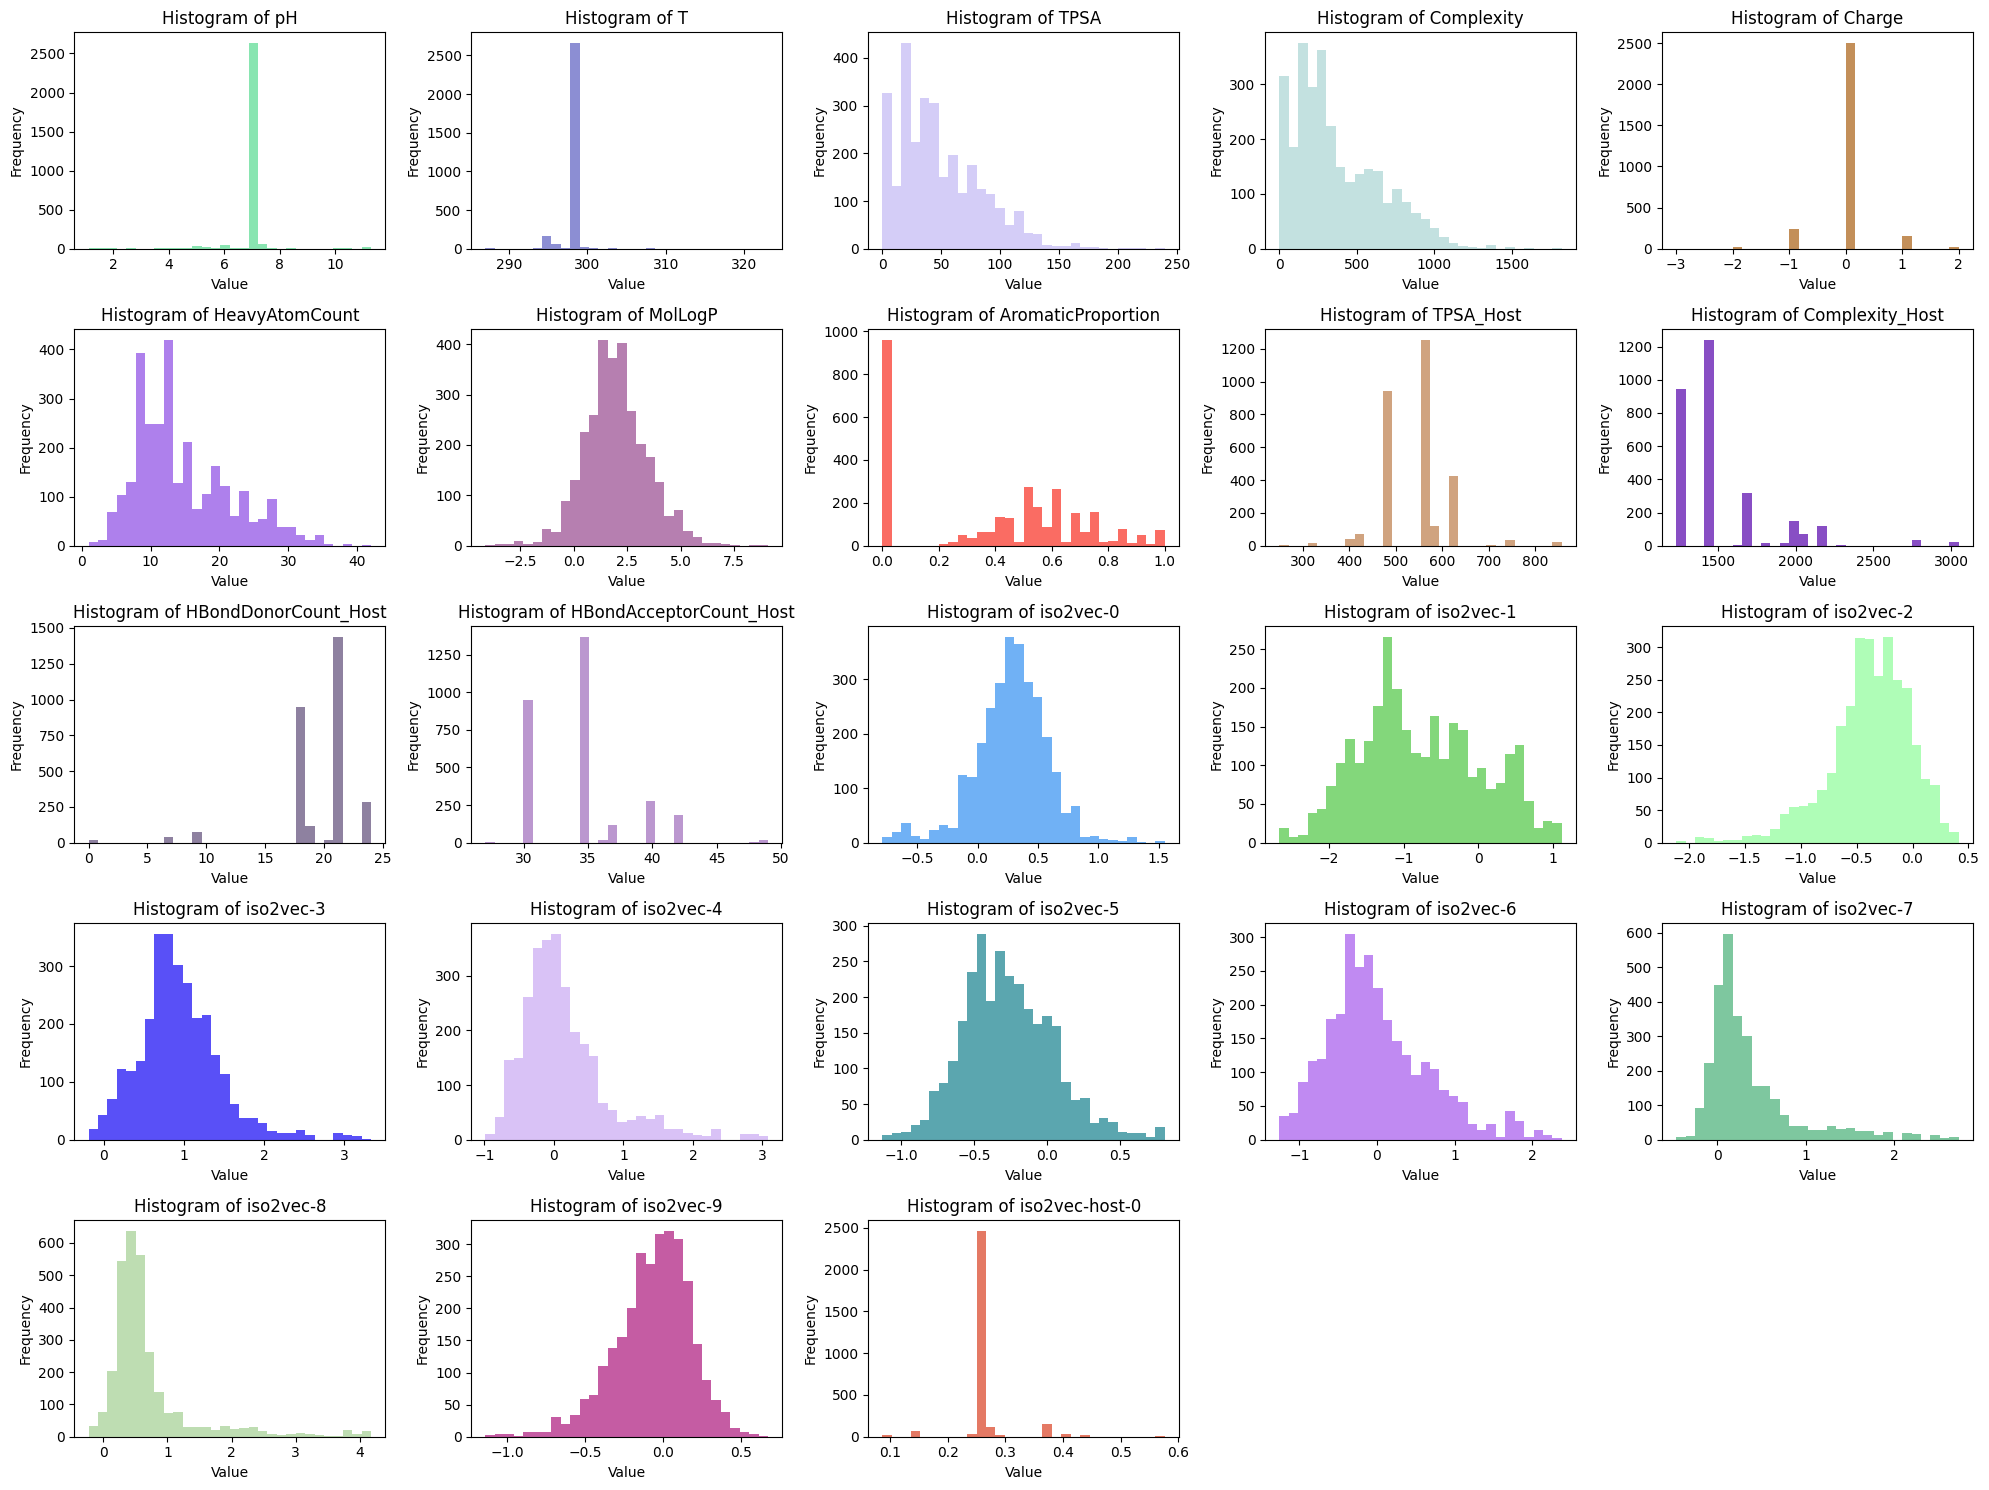

In [41]:
num_plots = len(X.columns)
columns = 5
rows = (num_plots + columns - 1) // columns  # Round up to fit all plots

# Create subplots
fig, axes = plt.subplots(rows, columns, figsize=(columns * 4, rows * 3))  # Adjust figure size
axes = axes.flatten()  # Flatten axes array for easy indexing

# Plot each histogram
for i in range(len(X.columns)):
    axes[i].hist(X[X.columns[i]], bins=30, alpha=0.7, color=np.random.rand(3,))
    axes[i].set_title(f'Histogram of {X.columns[i]}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(num_plots, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

In [85]:
def good_log(x):
    epsilon = 0.0001
    return np.sign(x)*np.log10(np.abs(x)+epsilon)
def good_sqrt(x):
    return np.sign(x)*np.sqrt(np.abs(x))
def good_division(a,b,mean):
    if b==0: 
        return a/mean
    return a/b
def good_pow_inverse(x,power):
    return np.sign(x)*(np.abs(x))**(power)

In [62]:
X_engineered = X.copy()

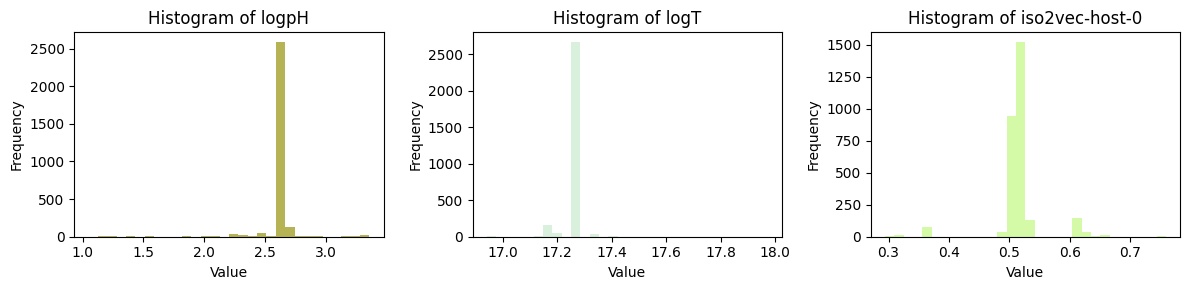

In [72]:
num_plots = 3
columns = 3
rows = (num_plots + columns - 1) // columns  # Round up to fit all plots

# Create subplots
fig, axes = plt.subplots(rows, columns, figsize=(columns * 4, rows * 3))  # Adjust figure size
axes = axes.flatten()  # Flatten axes array for easy indexing

# Plot each histogram

axes[0].hist(good_sqrt(list(X_engineered['pH'])), bins=30, alpha=0.7, color=np.random.rand(3,))
axes[0].set_title(f'Histogram of logpH')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

axes[1].hist(good_sqrt(list(X_engineered['T'])), bins=30, alpha=0.7, color=np.random.rand(3,))
axes[1].set_title(f'Histogram of logT')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

axes[2].hist(good_sqrt(list(X_engineered['iso2vec-host-0'])) , bins=30, alpha=0.7, color=np.random.rand(3,))
axes[2].set_title(f'Histogram of iso2vec-host-0')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(num_plots, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

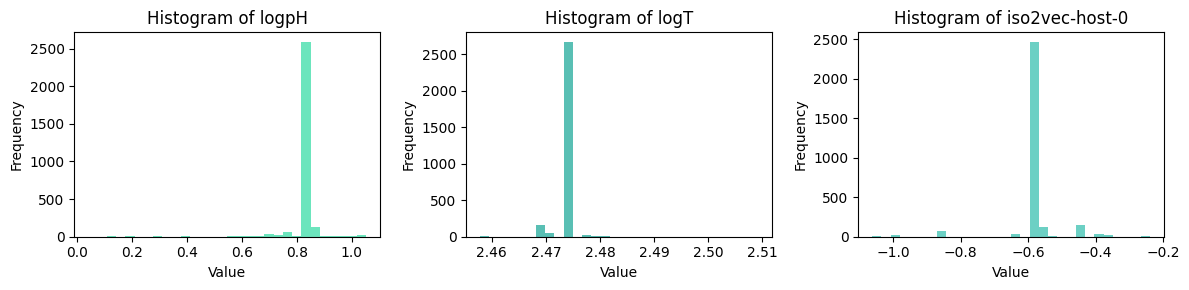

In [73]:
num_plots = 3
columns = 3
rows = (num_plots + columns - 1) // columns  # Round up to fit all plots

# Create subplots
fig, axes = plt.subplots(rows, columns, figsize=(columns * 4, rows * 3))  # Adjust figure size
axes = axes.flatten()  # Flatten axes array for easy indexing

# Plot each histogram

axes[0].hist(good_log(list(X_engineered['pH'])), bins=30, alpha=0.7, color=np.random.rand(3,))
axes[0].set_title(f'Histogram of logpH')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

axes[1].hist( good_log(list(X_engineered['T'])), bins=30, alpha=0.7, color=np.random.rand(3,))
axes[1].set_title(f'Histogram of logT')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

axes[2].hist( good_log(list(X_engineered['iso2vec-host-0'])) , bins=30, alpha=0.7, color=np.random.rand(3,))
axes[2].set_title(f'Histogram of iso2vec-host-0')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(num_plots, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

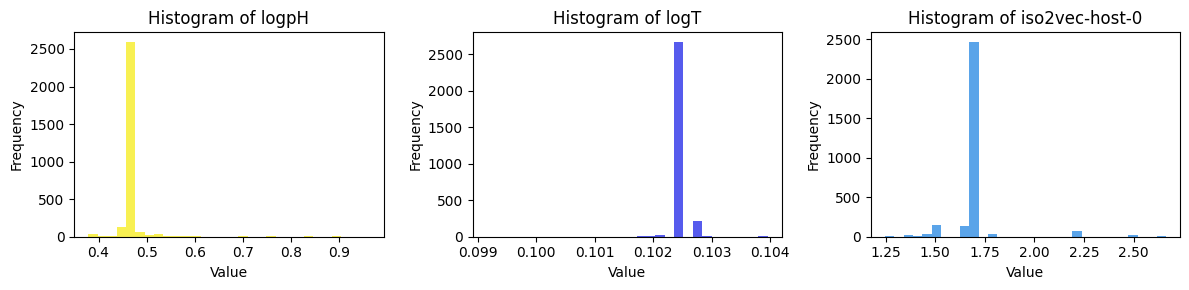

In [65]:
num_plots = 3
columns = 3
rows = (num_plots + columns - 1) // columns  # Round up to fit all plots

# Create subplots
fig, axes = plt.subplots(rows, columns, figsize=(columns * 4, rows * 3))  # Adjust figure size
axes = axes.flatten()  # Flatten axes array for easy indexing

# Plot each histogram
power = -0.4

axes[0].hist(good_pow_inverse(list(X_engineered['pH']),power), bins=30, alpha=0.7, color=np.random.rand(3,))
axes[0].set_title(f'Histogram of logpH')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

axes[1].hist( good_pow_inverse(list(X_engineered['T']),power), bins=30, alpha=0.7, color=np.random.rand(3,))
axes[1].set_title(f'Histogram of logT')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

axes[2].hist( good_pow_inverse(list(X_engineered['iso2vec-host-0']),power) , bins=30, alpha=0.7, color=np.random.rand(3,))
axes[2].set_title(f'Histogram of iso2vec-host-0')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(num_plots, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

La distribution de iso2vec-host-0 et apparement meuiller par application du racine carre (sqrt), les autres variables n'ont pas changer de distribution avec la majorité des transformations faite. Nous ajoutons alors une autre variable 'iso2vec-host-0_sqrt'.

In [74]:
X_engineered['iso2vec-host-0_sqrt'] = good_log(list(X_engineered['iso2vec-host-0']))

In [75]:
MAE_score(XG_reg,X,y_train)
RMSE_score(XG_reg,X,y_train)
R2_score(XG_reg,X,y_train)

MAE Scores: [0.8767545  0.88072783 0.85083517 0.84923518 0.82568883]
Mean MAE Score en logK: 0.8566483033306174 (+/- 0.020155982919780047)
RMSE Scores: [1.22275348 1.22749168 1.19048198 1.18486717 1.15888722]
Mean RMSE Score en logK: 1.19689630451987 (+/- 0.025436998276650254)
R2 Scores: [0.64363995 0.6209514  0.62606696 0.62736242 0.64831869]
Mean R2 Score: 0.633 (+/- 0.021)


In [76]:
MAE_score(XG_reg,X_engineered,y_train)
RMSE_score(XG_reg,X_engineered,y_train)
R2_score(XG_reg,X_engineered,y_train)

MAE Scores: [0.88222473 0.87823883 0.84609341 0.85579226 0.8218396 ]
Mean MAE Score en logK: 0.8568377653513719 (+/- 0.022108410566043023)
RMSE Scores: [1.22680962 1.22578902 1.18820507 1.19162202 1.15867602]
Mean RMSE Score en logK: 1.1982203499069992 (+/- 0.02563191612853386)
R2 Scores: [0.64127178 0.62200224 0.62749596 0.62310154 0.64844686]
Mean R2 Score: 0.632 (+/- 0.021)


L'effet de cette transformation est apparement non significative neanmoins existant, puisqu'il a augmentee le MAE par 0.001, a dimiue le RMSE par 0.0007 et a le augmente le score R2 par 0.001 ( il a diminuee la variance de R2 sur les 5-fold par 0.001 mais augmente cette variance pour MAE (resp. RMSE) par 0.004 (resp.0.002)). Et donc, comme resultat initiale, le feature engineering a un impact sur les resultats, meme qu'il mineur, il merite notre etude, donc on va essayer de le mieux raffiner.

In [77]:
X_engineered['logT'] = good_log(list(X_engineered['T']))
X_engineered['logpH'] = good_log(list(X_engineered['pH']))

MAE_score(XG_reg,X_engineered,y_train)
RMSE_score(XG_reg,X_engineered,y_train)
R2_score(XG_reg,X_engineered,y_train)

On remarque que lorsque nous ajoutons plus de relations des variables 'logT' et 'logpH',evidemment les valeurs de MAE, RMSE ont diminuee, et le R2 Score est le meme (mais sa variance a diminuee).
Cette approach preuve son potentiel a capte des informations cachees, neanmoins il est tres difficile à etudier manuellement, nous utilisons alors des techniques et algorithmes pour automatisee ce travail

In [82]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split


tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(X_engineered, y_train)

# Export the optimized pipeline
tpot.export('tpot_pipeline.py')


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1.39531124468832

Generation 2 - Current best internal CV score: -1.39531124468832

Generation 3 - Current best internal CV score: -1.39531124468832


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=100)


L'utilisation du TPOT n'a pas affichee des resultats, donc cette methode n'a pas reussi

Nous utilisons alors le : Genetic Programming for Feature Selection, ce qui est analogue a la selection naturelle dans la theorie de Darwin. Et qui fait l'etude sur differentes generations successives

In [83]:
from deap import base, creator, tools, algorithms
import pandas as pd
import numpy as np


def signed_log(x, epsilon=1e-8):
    return np.sign(x) * np.log(np.abs(x) + epsilon)

def signed_sqrt(x):
    return np.sign(x) * np.sqrt(np.abs(x))

try:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
except AttributeError:
    pass

try:
    creator.create("Individual", list, fitness=creator.FitnessMax)
except AttributeError:
    pass

toolbox = base.Toolbox()

def random_expression():
    feature_1, feature_2 = np.random.choice(X_engineered.columns, 2, replace=False)
    operation = np.random.choice(["+", "-", "*", "/", "signed_log", "signed_sqrt"])
    if operation in ["signed_log", "signed_sqrt"]:
        return f"{operation}(X['{feature_1}'] + 1e-8)"
    return f"X['{feature_1}'] {operation} X['{feature_2}']"

toolbox.register("attr_expr", random_expression)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_expr, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate_individual(individual):
    new_features = []
    for expr in individual:
        try:
            # Safely evaluate the mathematical expression
            new_feature = eval(expr, {}, {
                "X_engineered": X_engineered,
                "np": np,
                "signed_log": signed_log,
                "signed_sqrt": signed_sqrt
            })
            if np.any(np.isnan(new_feature)) or np.any(np.isinf(new_feature)):
                raise ValueError("Invalid values in feature transformation")
            new_features.append(new_feature)
        except Exception:
            return -np.inf,  # Penalize invalid transformations

    if new_features:
        # Combine original features with valid new features
        X_new = pd.concat([X_engineered, pd.DataFrame(new_features).T], axis=1)
    else:
        X_new = X_engineered

    model = XG_reg
    scores = cross_val_score(model, X_new.values, y, cv=3, scoring="neg_mean_squared_error", error_score='raise')
    return np.mean(scores),
    
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(X_engineered.columns)-1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=20)
NGEN = 10
CXPB, MUTPB = 0.5, 0.2

for gen in range(NGEN):
    print(f"Generation {gen}")
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = list(map(toolbox.evaluate, offspring))
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

best_ind = tools.selBest(population, k=1)[0]
print("Best Individual:", best_ind)

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Best Individual: ["X['iso2vec-4'] / X['HBondAcceptorCount_Host']", 11, "X['HeavyAtomCount'] + X['Charge']", 18, "X['HBondAcceptorCount_Host'] * X['Complexity']"]


C:\Users\G\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Nous essayons alros les propositions du genetic selection

In [87]:
vectorized_divison = np.vectorize(good_division)
X_engineered['iso2Hbond'] = vectorized_divison(list(X['iso2vec-4']), list(X['HBondAcceptorCount_Host']),np.mean(X['HBondAcceptorCount_Host']))
X_engineered['Heavy_Charge'] = X_engineered['HeavyAtomCount'] + X_engineered['Charge']
X_engineered ['HBond_complex'] = X_engineered['HBondAcceptorCount_Host'] * X_engineered['Complexity']

In [89]:
MAE_score(XG_reg,X_engineered,y_train)
RMSE_score(XG_reg,X_engineered,y_train)
R2_score(XG_reg,X_engineered,y_train)

MAE Scores: [0.8810213  0.88273154 0.85107857 0.85773492 0.82892889]
Mean MAE Score en logK: 0.8602990453363788 (+/- 0.02004149335860336)
RMSE Scores: [1.22283295 1.22892362 1.19397839 1.1953909  1.16561887]
Mean RMSE Score en logK: 1.2013489449798704 (+/- 0.02275252368754762)
R2 Scores: [0.64359363 0.62006652 0.62386727 0.62071365 0.64422119]
Mean R2 Score: 0.630 (+/- 0.022)


Comme tentative finale, nous essayons d'ajouter les relations qui se presentent dans le mondre reel entre les differentes variables

In [98]:
import pandas as pd
import numpy as np

# Assume X_engineered is your input DataFrame containing the initial features
# Here's a basic structure of how the data might look:
# X_engineered = pd.DataFrame(...)

def feature_engineering(X_engineered):
    # Interaction terms between different features
    X_engineered['pH_Charge'] = X_engineered['pH'] * X_engineered['Charge']
    X_engineered['T_logP'] = X_engineered['T'] * X_engineered['MolLogP']
    X_engineered['Complexity_HeavyAtomCount'] = X_engineered['Complexity'] * X_engineered['HeavyAtomCount']
    X_engineered['AromaticProportion_LogP'] = X_engineered['AromaticProportion'] * X_engineered['MolLogP']
    
    # Pairwise interactions of iso2vec features (example for first 3 iso2vec features)
    for i in range(9):
        for j in range(i+1, 10):
            X_engineered[f'iso2vec-{i}_iso2vec-{j}'] = X_engineered[f'iso2vec-{i}'] * X_engineered[f'iso2vec-{j}']
    
    # Interactions between host and guest-related features
    X_engineered['TPSA_Host_TPSA'] = X_engineered['TPSA_Host'] * X_engineered['TPSA']
    
    # Host-guest iso2vec interactions (example for iso2vec-0 to iso2vec-host-0)
    for i in range(10):
        X_engineered[f'iso2vec-{i}_iso2vec-host-0'] = X_engineered[f'iso2vec-{i}'] * X_engineered['iso2vec-host-0']
    
    
    # Create ratios and normalized versions of Charge and HeavyAtomCount
    X_engineered['Heavy_Charge'] = X_engineered['HeavyAtomCount'] * X_engineered['Charge']
    X_engineered['Heavy_Charge_to_HeavyAtomCount'] = X_engineered['Heavy_Charge'] / (X_engineered['HeavyAtomCount'] + 1e-6)
    
    # Polynomial features (e.g., for TPSA, LogP, etc.)
    X_engineered['TPSA_squared'] = X_engineered['TPSA'] ** 2
    X_engineered['logP_squared'] = X_engineered['MolLogP'] ** 2
    X_engineered['logP_TPSA'] = X_engineered['MolLogP'] * X_engineered['TPSA']
    

    
    # Returning the new engineered DataFrame
    return X_engineered

# Apply feature engineering to the DataFrame
X_engineered = feature_engineering(X_engineered)

# Display the newly engineered features
print(X_engineered.head())


    pH      T    TPSA  Complexity  Charge  HeavyAtomCount  MolLogP  \
0  7.0  298.0   20.23   29.368066       0               8   1.9491   
1  7.0  298.0  129.80  940.563932       0              26   0.9028   
2  6.9  298.0   46.50  284.649333       0              13   2.1466   
3  7.0  298.0    0.00    2.000000       0               2   0.5460   
4  7.0  298.0   74.97  967.433029       0              23   2.2765   

   AromaticProportion  TPSA_Host  Complexity_Host  ...  \
0            0.000000     633.20      1704.413059  ...   
1            0.384615     554.05      1467.088147  ...   
2            0.000000     554.05      1467.088147  ...   
3            0.000000     618.66      1996.520905  ...   
4            0.434783     837.41      3047.539511  ...   

   iso2vec-4_iso2vec-host-0  iso2vec-5_iso2vec-host-0  \
0                  0.561769                  0.130579   
1                  0.075255                 -0.049744   
2                  0.147243                  0.006813   
3 

In [99]:
MAE_score(XG_reg,X_engineered,y_train)
RMSE_score(XG_reg,X_engineered,y_train)
R2_score(XG_reg,X_engineered,y_train)

MAE Scores: [0.90292956 0.90319086 0.86705895 0.86696097 0.84406975]
Mean MAE Score en logK: 0.8768420209199588 (+/- 0.022987764643591882)
RMSE Scores: [1.25699437 1.24753739 1.20600639 1.2064204  1.19346119]
Mean RMSE Score en logK: 1.222083950222415 (+/- 0.025257523186629202)
R2 Scores: [0.62340213 0.60847011 0.61625087 0.61368225 0.62702171]
Mean R2 Score: 0.618 (+/- 0.013)


In [107]:
def create_interaction_terms(data):
    interaction_data = data.copy()

    # Within-Group Interactions
    interaction_data['HBondDonorCount_x_HBondAcceptorCount'] = (
        data['HBondDonorCount'] * data['HBondAcceptorCount']
    )
    interaction_data['MolecularWeight_x_TPSA'] = (
        data['MolecularWeight'] * data['TPSA']
    )
    interaction_data['Complexity_x_Charge'] = (
        data['Complexity'] * data['Charge']
    )
    interaction_data['AromaticProportion_x_MolLogP'] = (
        data['AromaticProportion'] * data['MolLogP']
    )

    # Cross-Group Interactions
    interaction_data['HBondDonorCount_x_HBondDonorCount_Host'] = (
        data['HBondDonorCount'] * data['HBondDonorCount_Host']
    )
    interaction_data['HBondAcceptorCount_x_HBondAcceptorCount_Host'] = (
        data['HBondAcceptorCount'] * data['HBondAcceptorCount_Host']
    )
    interaction_data['MolecularWeight_x_MolecularWeight_Host'] = (
        data['MolecularWeight'] * data['MolecularWeight_Host']
    )
    interaction_data['TPSA_x_TPSA_Host'] = data['TPSA'] * data['TPSA_Host']
    interaction_data['Complexity_x_Complexity_Host'] = (
        data['Complexity'] * data['Complexity_Host']
    )
    interaction_data['HeavyAtomCount_x_HeavyAtomCount_Host'] = (
        data['HeavyAtomCount'] * data['HeavyAtomCount_Host']
    )

    # Host-Guest Differences
    interaction_data['HBondDonorCount_diff_HBondDonorCount_Host'] = (
        data['HBondDonorCount'] - data['HBondDonorCount_Host']
    )
    interaction_data['HBondAcceptorCount_diff_HBondAcceptorCount_Host'] = (
        data['HBondAcceptorCount'] - data['HBondAcceptorCount_Host']
    )
    interaction_data['MolecularWeight_diff_MolecularWeight_Host'] = (
        data['MolecularWeight'] - data['MolecularWeight_Host']
    )
    interaction_data['TPSA_diff_TPSA_Host'] = data['TPSA'] - data['TPSA_Host']
    interaction_data['Complexity_diff_Complexity_Host'] = (
        data['Complexity'] - data['Complexity_Host']
    )

    # Ratios
    interaction_data['HBondDonorCount_ratio_HBondDonorCount_Host'] = (
        data['HBondDonorCount'] / (data['HBondDonorCount_Host'] + 1e-9)
    )
    interaction_data['HBondAcceptorCount_ratio_HBondAcceptorCount_Host'] = (
        data['HBondAcceptorCount'] / (data['HBondAcceptorCount_Host'] + 1e-9)
    )
    interaction_data['MolecularWeight_ratio_MolecularWeight_Host'] = (
        data['MolecularWeight'] / (data['MolecularWeight_Host'] + 1e-9)
    )
    interaction_data['TPSA_ratio_TPSA_Host'] = (
        data['TPSA'] / (data['TPSA_Host'] + 1e-9)
    )
    interaction_data['Complexity_ratio_Complexity_Host'] = (
        data['Complexity'] / (data['Complexity_Host'] + 1e-9)
    )

    # Iso2vec Interactions
    for i in range(10):
        guest_col = f'iso2vec-{i}'
        host_col = f'iso2vec-host-{i}'
        interaction_data[f'{guest_col}_x_{host_col}'] = (
            data[guest_col] * data[host_col]
        )
        interaction_data[f'{guest_col}_diff_{host_col}'] = (
            data[guest_col] - data[host_col]
        )

    # Environmental Interactions
    interaction_data['pH_x_HBondDonorCount'] = data['pH'] * data['HBondDonorCount']
    interaction_data['pH_x_MolLogP'] = data['pH'] * data['MolLogP']
    interaction_data['T_x_MolecularWeight'] = data['T'] * data['MolecularWeight']
    interaction_data['T_x_Complexity_Host'] = data['T'] * data['Complexity_Host']

    return interaction_data

X_new = x_train.copy().drop(['logK','K'],axis=1)
# X_new = x_train.drop(columns_to_not_consider,axis=1)
# Apply the interaction terms function
x_train_interactions = create_interaction_terms(X_new)

# Display the resulting dataset shape and columns
x_train_interactions.shape, x_train_interactions.columns


((2940, 81),
 Index(['pH', 'T', 'TPSA', 'MolecularWeight', 'Complexity', 'Charge',
        'HBondDonorCount', 'HBondAcceptorCount', 'HeavyAtomCount', 'MolLogP',
        'AromaticProportion', 'TPSA_Host', 'MolecularWeight_Host',
        'Complexity_Host', 'HBondDonorCount_Host', 'HBondAcceptorCount_Host',
        'HeavyAtomCount_Host', 'iso2vec-0', 'iso2vec-1', 'iso2vec-2',
        'iso2vec-3', 'iso2vec-4', 'iso2vec-5', 'iso2vec-6', 'iso2vec-7',
        'iso2vec-8', 'iso2vec-9', 'iso2vec-host-0', 'iso2vec-host-1',
        'iso2vec-host-2', 'iso2vec-host-3', 'iso2vec-host-4', 'iso2vec-host-5',
        'iso2vec-host-6', 'iso2vec-host-7', 'iso2vec-host-8', 'iso2vec-host-9',
        'HBondDonorCount_x_HBondAcceptorCount', 'MolecularWeight_x_TPSA',
        'Complexity_x_Charge', 'AromaticProportion_x_MolLogP',
        'HBondDonorCount_x_HBondDonorCount_Host',
        'HBondAcceptorCount_x_HBondAcceptorCount_Host',
        'MolecularWeight_x_MolecularWeight_Host', 'TPSA_x_TPSA_Host',
        

Si nous essayons le feature engineering sur toutes le colonnes possibles ( meme ceux que nous avons eliminer avant sauf les variables categorique), c'est une approche qui a un defaut fatal, ce qui est le "Fléau de la dimension" ou le "Curse of dimensionality"

In [109]:
MAE_score(XG_reg,x_train_interactions,y_train)
RMSE_score(XG_reg,x_train_interactions,y_train)
R2_score(XG_reg,x_train_interactions,y_train)

MAE Scores: [0.87794631 0.87548021 0.86367483 0.83295041 0.82865702]
Mean MAE Score en logK: 0.8557417547996519 (+/- 0.02096955177851789)
RMSE Scores: [1.23232726 1.22122334 1.20896269 1.18955699 1.16167905]
Mean RMSE Score en logK: 1.2027498671325876 (+/- 0.0249621891995887)
R2 Scores: [0.63803773 0.62481284 0.61436718 0.62440671 0.6466222 ]
Mean R2 Score: 0.630 (+/- 0.023)


Comme dereniere tentative pour ameliorer les predictions de notre model en se basant sur le feature engineering, nous avons utilisee la data augmentation en utilisant le Bootstraping[3]. Cette technique a bien ameliorer la perforamance du model (Le MAE a diminué jusqu'à 0.60, RMSE jusqu'à 0.80 et le R2 a augmentee jusqu'a 70% en cross_validation avec 5-fold). Ce résultat peut etre benefique lors de l'interpretation des resultats, mais n'ont pas lors de l'entrainement. En effet, une amelioration du modele apres le Bootstraping signifie que si nous avons une distrbution plus uniform des donnes, le model est capable de plus se generaliser. Neanmoins, un entrainment sur ce nouveau jeu de donnees pour le but de predire une base de donnes similaire a la premiere risque de faire des hypotheses inexistant dans le cas reel. Par exemple, dans notre cas ca peut arriver que les valeurs de K grandes sont rare dans la nature, et donc la distribution de K est par definition non uniform. C'est pourquoi nous avons decider de ne pas utiliser cette methode.

Les resultat du feature engineering montre leur importance, de la creation des relations simples entre les variables à la creation des relations plus complexes en utilisant des techniques avancees, ou mieux si possible, de creer des relations basées sur une expertise dans le domaine de la chimie.
Ces approches sont couteux et difficilement accessible a cause du caractere couteux des algorithmes de feature engineering avancee comme le TPOT ou le H2o AutoML, et leurs nature qui complexe qui necessite des computations puissant. De plus, la deuxieme method, necessite l'access a des expert dans le domaine, ce qui est rarement le cas sauf dans le domaine industriel. Des fatalites de cette approche vient du "Curse of dimenstionality", puisque de plus en plus que nous augmentons le nombre de variables, de plus en plus que l'etude deviendra tres complexe est risque de creer plus de bruit, et de plus les calculs deviendront beacoup plus couteux.
Comme conclusion sur cette partie, le feature engineering a montree ca valeur et son potentiel a raffinee le model, mais il necessite une etude plus profonde avec beaucoup de ressources differentes. 

LE TESTING
Nous avons la dataset x_test que nous pouvons predire, on va faire la prediction sur logK, en appliquant sur la x_test les modifications finales que nous avons appliquees sur la data d'entrainement.

In [134]:
x_test = dataset_test.drop(['Host','Original_Value','Guest','Erreur','CID_Host',"Reference","CID_Guest",'Charge_Host',"IsomericSMILES_Host","IsomericSMILES"],axis=1)
cols = [col for col in columns_to_not_consider if col not in ['K','logK']]

x_test = x_test.drop(cols,axis=1)
X_train = x_train.drop(columns_to_not_consider,axis=1)
X_train['iso2vec-host-0_sqrt'] = good_log(list(X_train['iso2vec-host-0']))
X_train['logT'] = good_log(list(X_train['T']))
X_train['logpH'] = good_log(list(X_train['pH']))
x_test['iso2vec-host-0_sqrt'] = good_log(list(x_test['iso2vec-host-0']))
x_test['logT'] = good_log(list(x_test['T']))
x_test['logpH'] = good_log(list(x_test['pH']))

XG_reg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [135]:
logK_prediction = XG_reg.predict(x_test)

Text(0.5, 1.0, 'Distribution des valeurs de logK prediction')

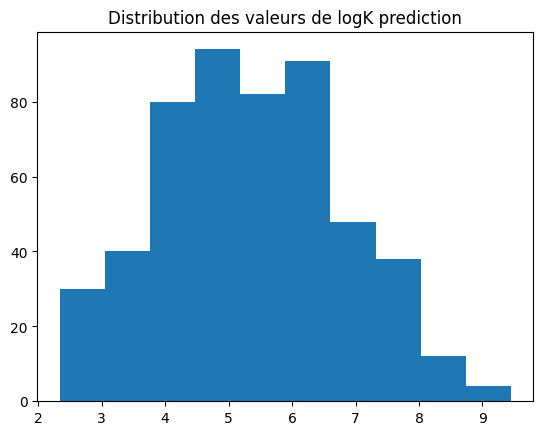

In [139]:
plt.hist(logK_prediction)
plt.title('Distribution des valeurs de logK prediction')

INTERPRETATION DU RESULTAT MAE, RMSE ET ACC ENVOYEE PAR MAIL

Les scores que nous avons trouvees sur mae, rmse et acc sur la data de test sont respectivement 1156.94, 4274.90 et acc = 0.79 pour K. pour logK, le score mae, rmse et acc sont respectivement : 1.06 , 1.33 et 0.79

Ce resultat peut etre interprete comme un bon resultat puisque le modele arrive a faire une prediction avec une precision de 0.79 sur la data de test, les valeurs de mae et rmse sont relativement grande, mais ils dependent de la nature du jeu de donnees ou des grandes valeurs de K existent.

Remarques : 
- Lors du premier calcul envoyees, nous avons envoyees les valeurs de K avec le "Bias correction for log-transformed regression", est donc pour nous la priorité était le calcul de K et non pas logK.
- L'acc trouvait est de 0.79, neanmoins c'est la mesure sur quelle variable qui decide la valeur de acc. par ce que une mesure sur K dans notre cas apres correction, donne une acc mieux qu'une mesure sur logK.

Resultat 
- Pour les nouvelles valeurs de K et logK envoyees, la correction ne sera pas faite, par ce que le calcul precis de logK est prioritaire.

Les methodes que nous avons aussi appliquées mais qui n'avaient pas d'effet sur la performance de notre model sont : 

Pour la data engineering:
    - Data Binning : On creer de nouvelles colonnes pour categoriser les valeurs a partir de leurs intervalles, eg. en creer trois colonnes ph1 et ph2 tel que les individus appartenant a ph1 (resp ph2) sont ceux appartenant ayant une valeur ph entre minpH et 7 (resp entre 7 et maxpH)
    - Clustering.

Pour les techniques d'entrainement du model:

Model Ensembling : Creation de plusieurs models en regroupant leurs predictions par des techniques comme le Bagging (entrainement des models de meme type) ou le Stacking (entrainement des modeles de differentes type) pour réaliser de meilleur predictions. Cette approach n'est pas necessaire dans notre cas, puisque nous utilisons le model XG_boost qui est deja un model basee sur des Forets aleatoires (qui sont eux meme basee sur le Model Ensembling), et le boosting qui optimise le model au cours de l'entrainement. Donc le resultat de la prediction reste a peut pres le meme.

CE QUE NOUS POURRONS AMELIORER : 

1. Comprendre mieux la nature de problem, i.e savoir est ce que nous avons arrivee à la limite possible du raffinement du model et donc dans ce cas le seul alternative d'amelioration est d'ajouter plus de donnees d'entrainement. Ou ci ce n'est pas le cas, nous avons d'autres relations encore cachees dans notre jeu de donnees.
2. Explorer plus les relations entre les differentes variables par les methodes de feature engineering mentionnes ci dessus, ou par d'autres methodes plus pousse. Ainsi qu'une recherche sur les differentes documentations ayant travaille sur des cas similaires.
3. Choix des modeles plus pousses comme les reseaux de neurones artificiels par qu'il sont beaucoup plus mieux grace a sa non-linearite intrinseque (Les fonctions d'activation non linéaires comme ReLU, sigmoid, ou tanh) et sa capacite de generalisation.

QUE FERIONS-NOUS SI NOUS POUVIONS REPARTIR DE ZERO

1. Consacrer une grande partie du travail au pretraitement de donnees puisqu'il joue le role le plus important dans la performance de notre model.
2. Faire une recherche sur la signification des differentes variables de notre jeu de donnes pour savoir lesquelles sont les plus importantes dans l'industrie.
3. Faire un fine tuning sur un nombre important des variables du model de regression xgboost puisque les parametres ont un impact majeur sur sa performance.
4. Explorer plus de relations entre les differentes variables en utilisant les differentes techniques de feature engineering.

Conclusion

A remplir ...

[1] https://wwwdisc.chimica.unipd.it/fabrizio.mancin/pubblica/Suprachem/BindingConstants_01_slides.pdf

[2] Feature Engineering for Machine
Learning
Principles and Techniques for Data Scientists by Alice Zheng and Amanda Casari

[3] https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/

[4] https://afrjournal.org/index.php/afr/article/download/66/226/0